From Santhosh Sarma's kernel (https://www.kaggle.com/sharmasanthosh/allstate-claims-severity/exploratory-study-on-ml-algorithms)

In [13]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings('ignore')

# Read raw data from the file

import pandas #provides data structures to quickly analyze data
#Since this code runs on Kaggle server, data can be accessed directly in the 'input' folder
#Read the train dataset
dataset = pandas.read_csv("../../datasets/allstate/train.csv") 

#Read test dataset
dataset_test = pandas.read_csv("../../datasets/allstate/test.csv")
#Save the id's for submission file
ID = dataset_test['id']
#Drop unnecessary columns
dataset_test.drop('id',axis=1,inplace=True)
dataset.drop(['id'],axis=1,inplace=True)

#Print all rows and columns. Dont hide any
pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_columns', None)

#get lists of numeric/categorical columns
numcols = dataset.select_dtypes(include=[np.number]).columns
catcols = dataset.drop(numcols, axis=1).columns

#range of features considered
split = 116 

#number of features considered
size = 15

#Display the first five rows to get a feel of the data
print(dataset.head(5))

#Learning : cat1 to cat116 contain alphabets

  cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9 cat10 cat11 cat12 cat13 cat14  \
0    A    B    A    B    A    A    A    A    B     A     B     A     A     A   
1    A    B    A    A    A    A    A    A    B     B     A     A     A     A   
2    A    B    A    A    B    A    A    A    B     B     B     B     B     A   
3    B    B    A    B    A    A    A    A    B     A     A     A     A     A   
4    A    B    A    B    A    A    A    A    B     B     A     B     A     A   

  cat15 cat16 cat17 cat18 cat19 cat20 cat21 cat22 cat23 cat24 cat25 cat26  \
0     A     A     A     A     A     A     A     A     B     A     A     A   
1     A     A     A     A     A     A     A     A     A     A     A     A   
2     A     A     A     A     A     A     A     A     A     A     A     A   
3     A     A     A     A     A     A     A     A     B     A     A     A   
4     A     A     A     A     A     A     A     A     B     A     A     A   

  cat27 cat28 cat29 cat30 cat31 cat32 cat33 cat34 cat35 

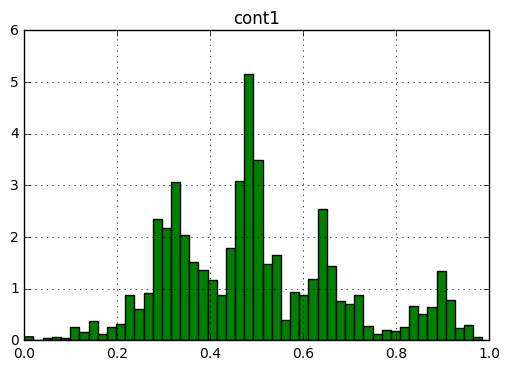

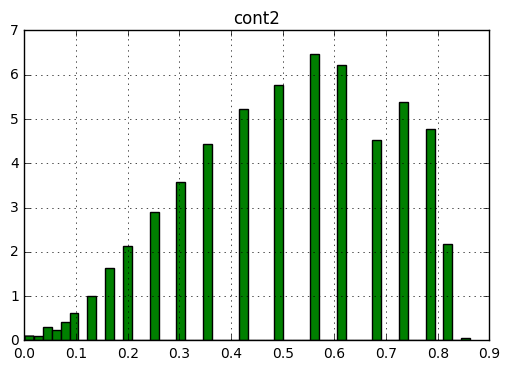

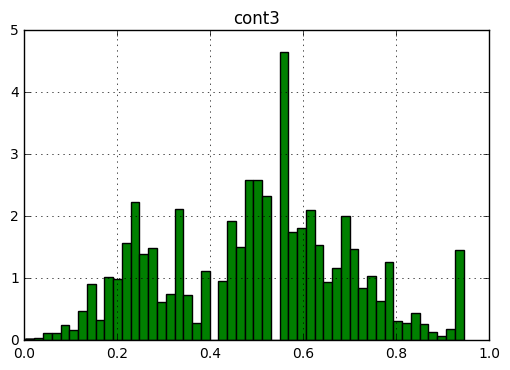

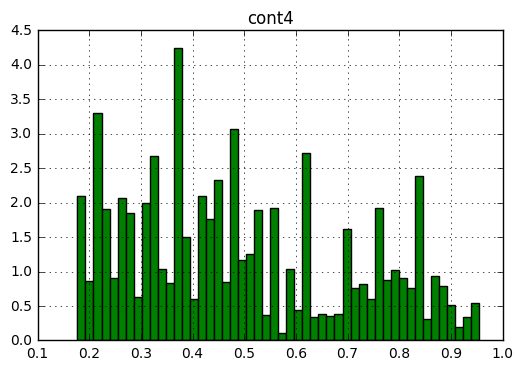

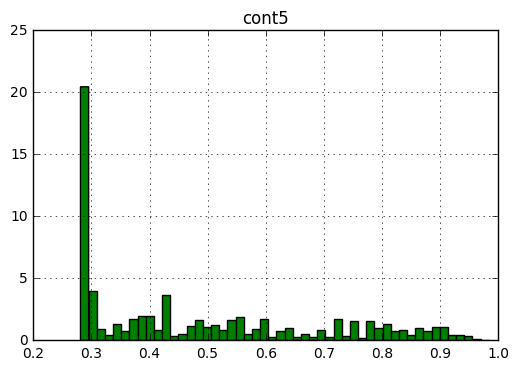

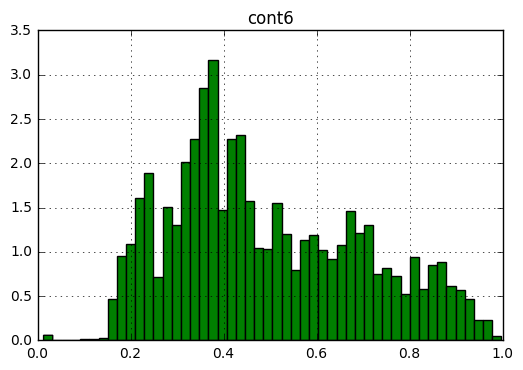

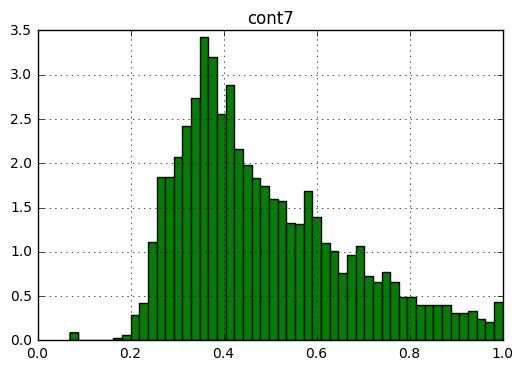

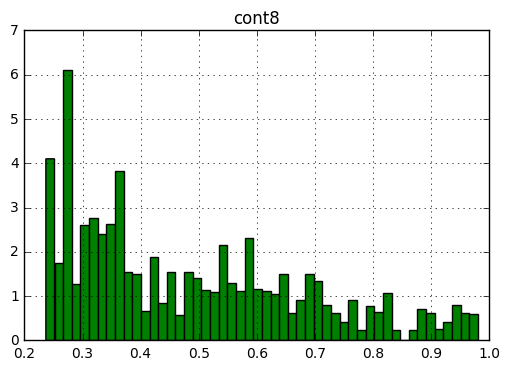

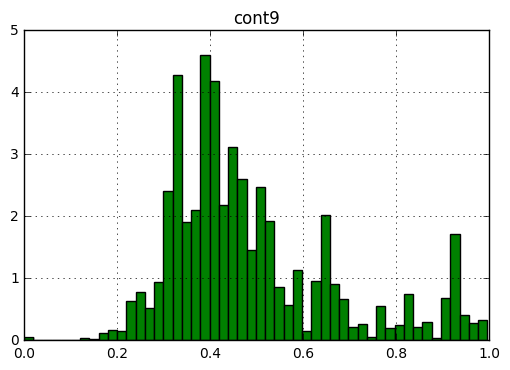

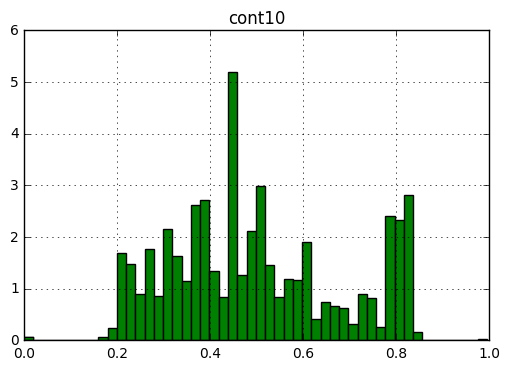

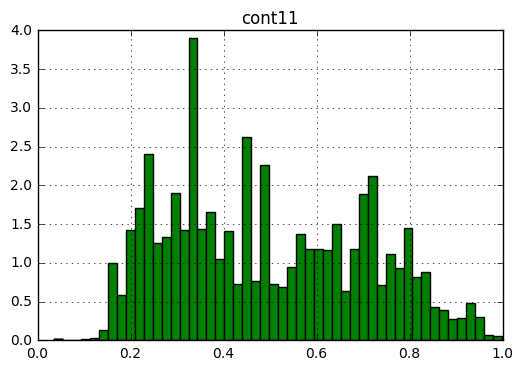

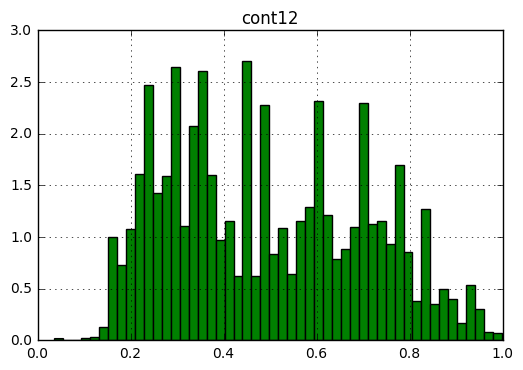

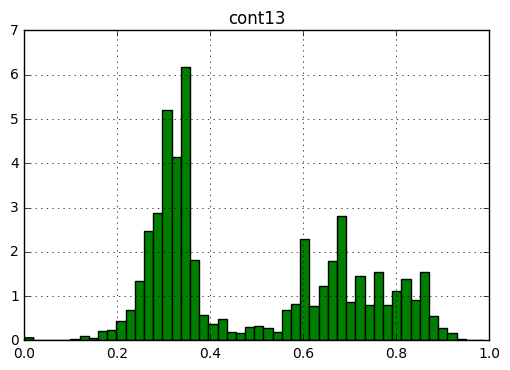

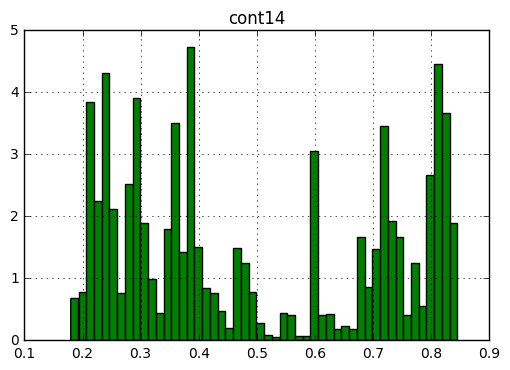

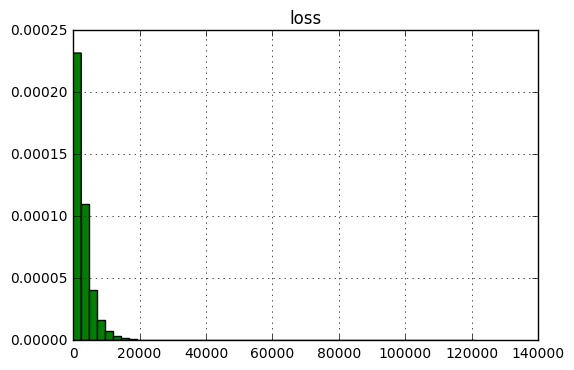

In [15]:
#plot continuous variables
for feat in numcols:
    n, bins, patches = plt.hist(dataset[feat], 50, normed=True, facecolor='green')
    plt.title(feat)
    plt.grid(True)
    plt.show()

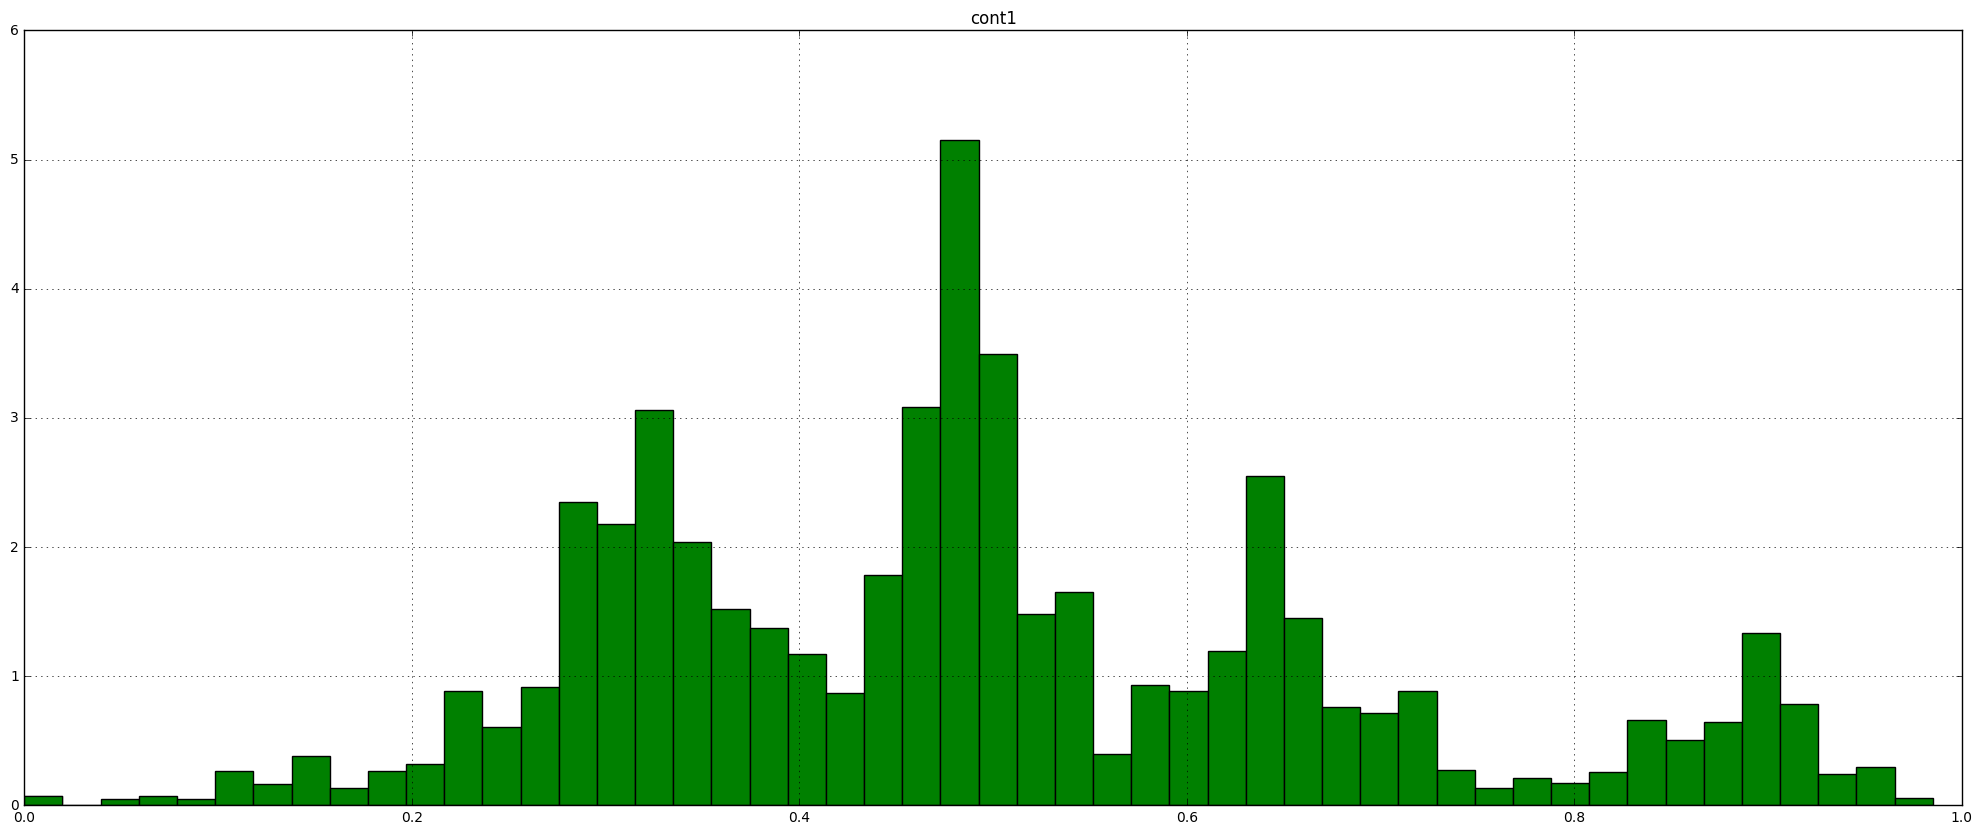

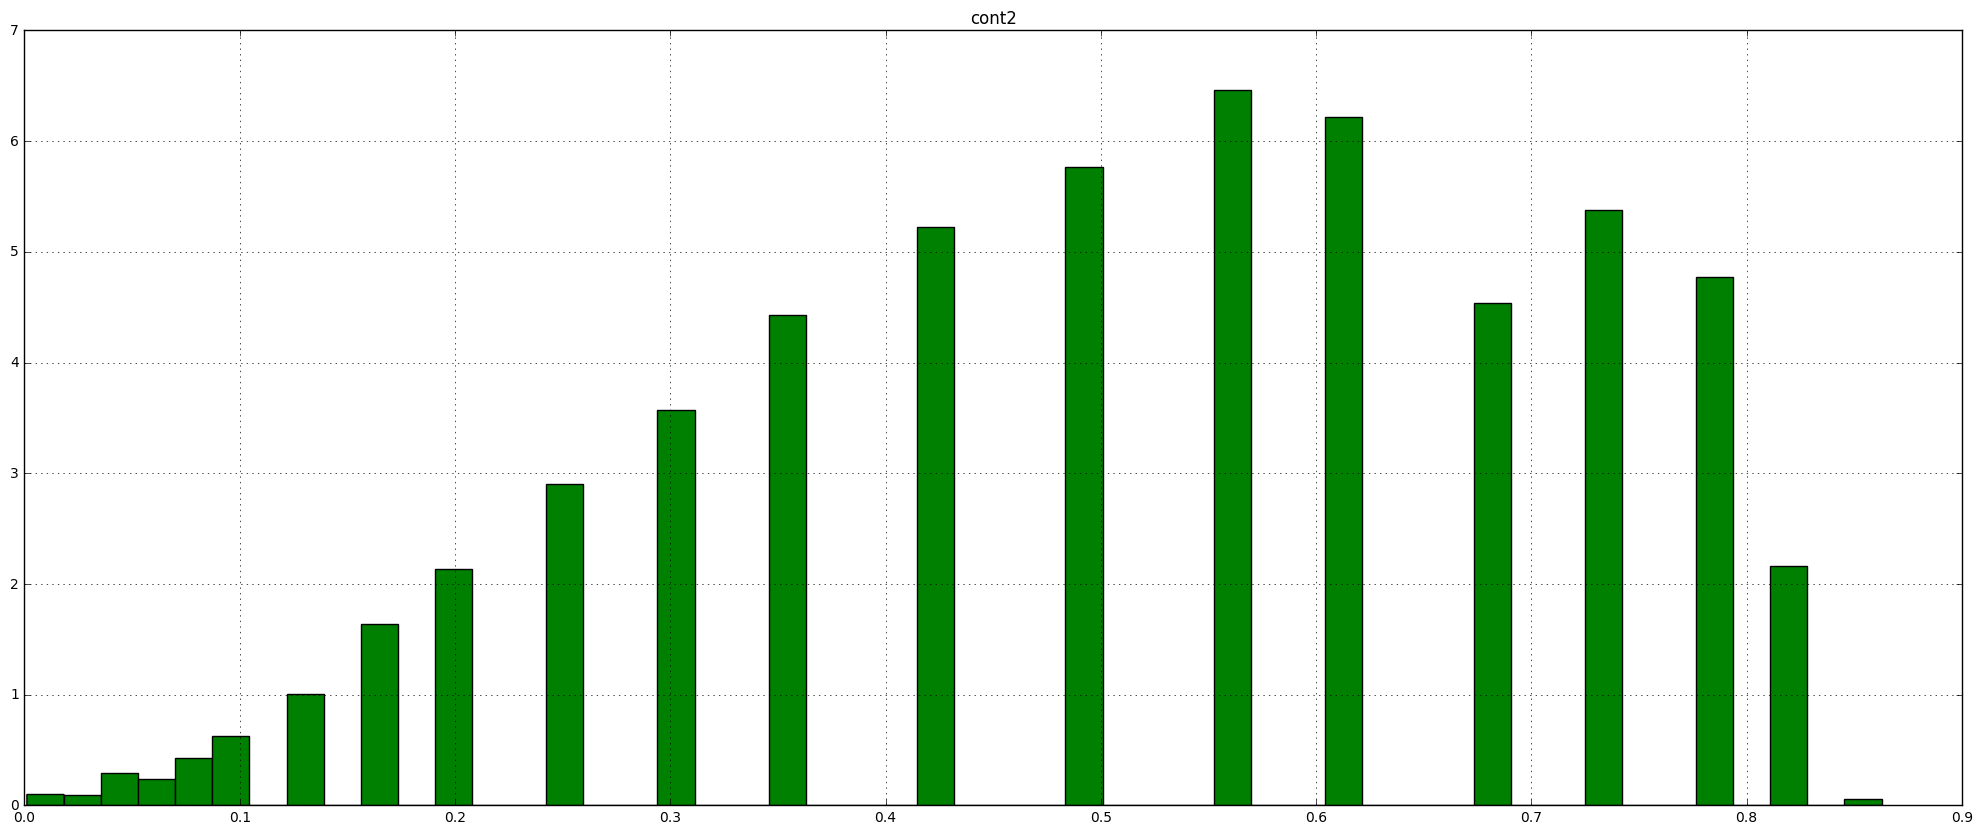

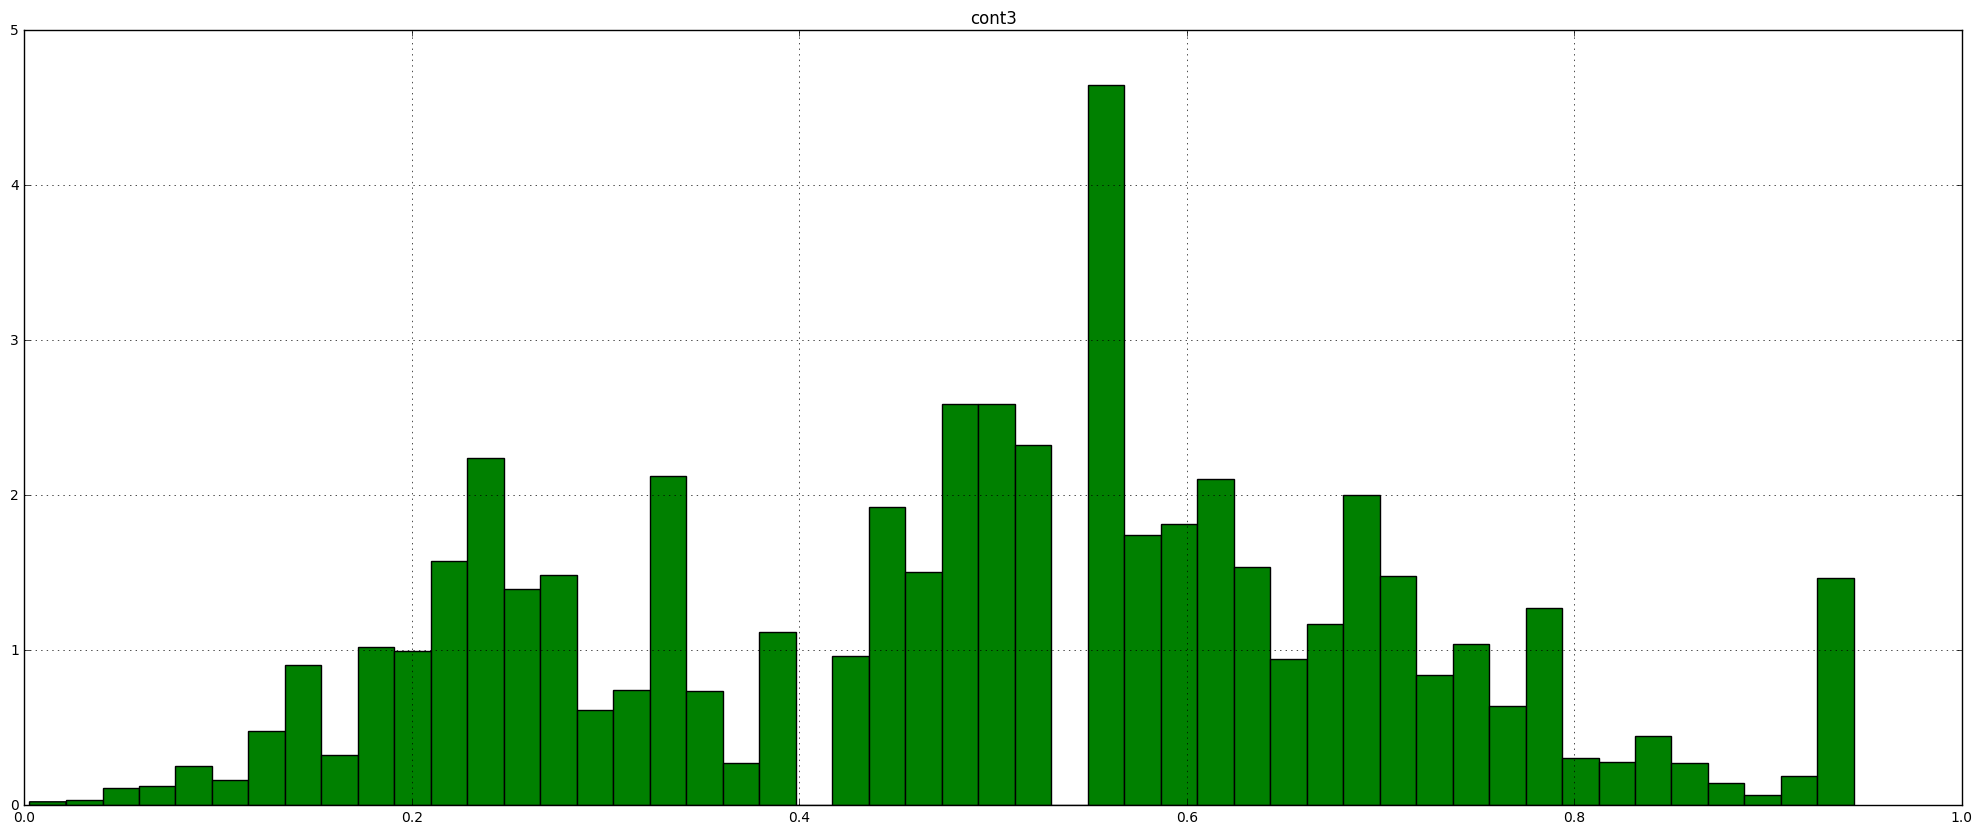

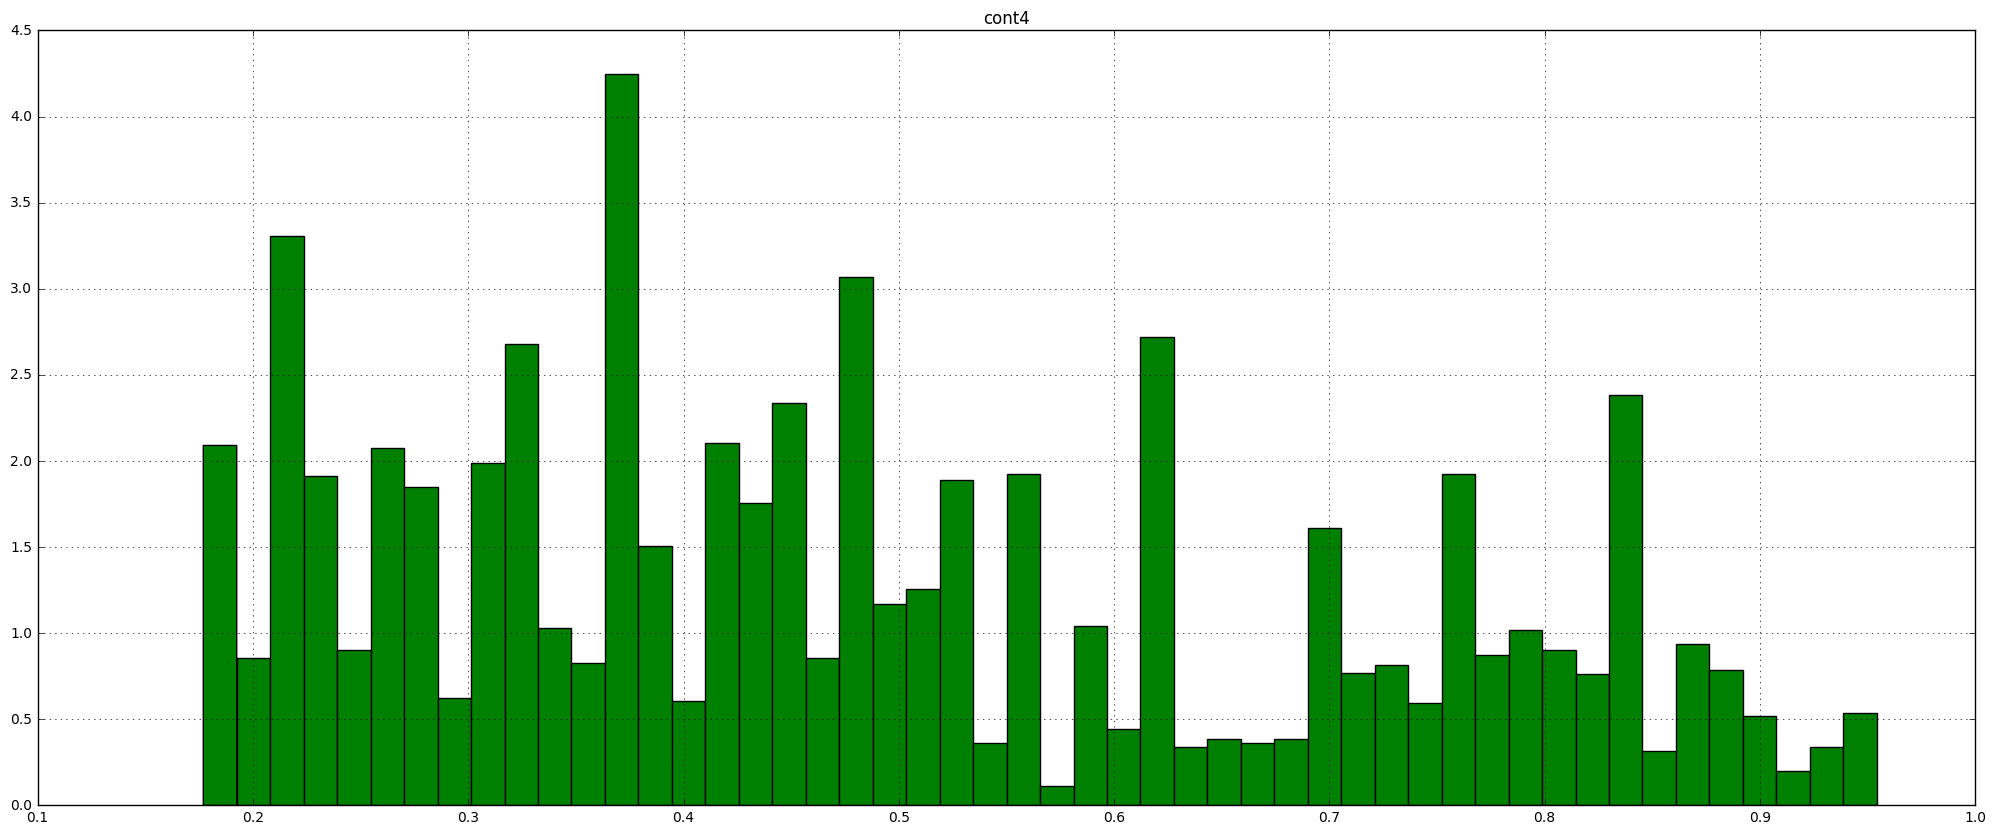

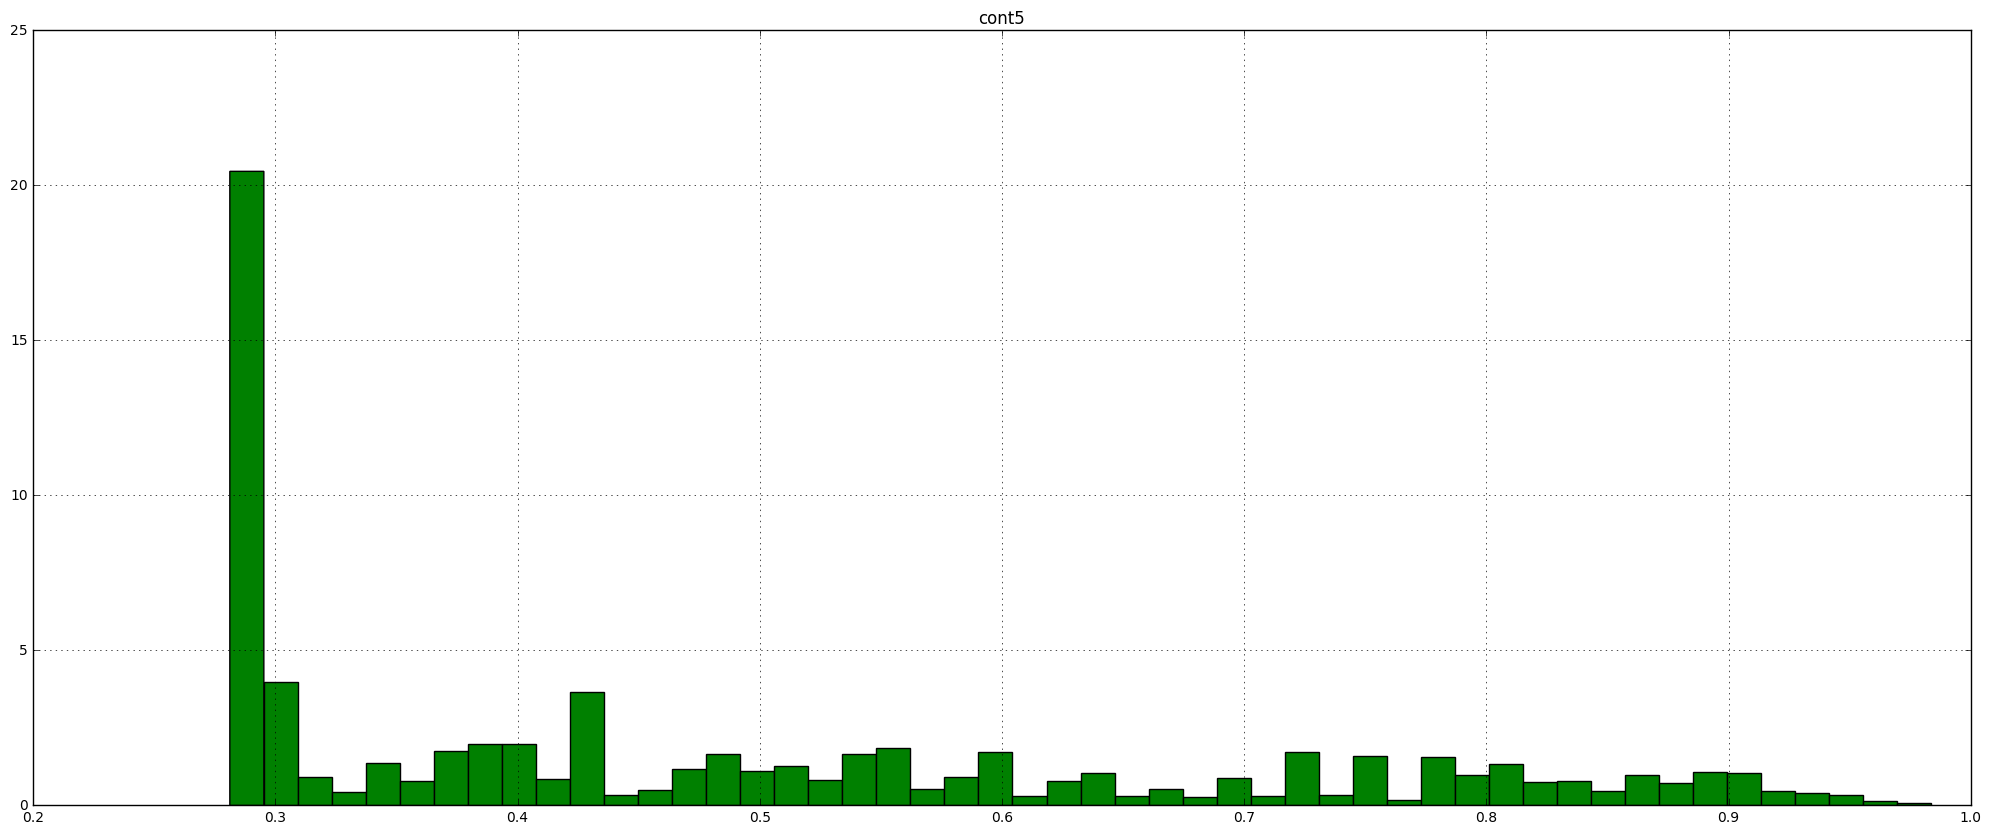

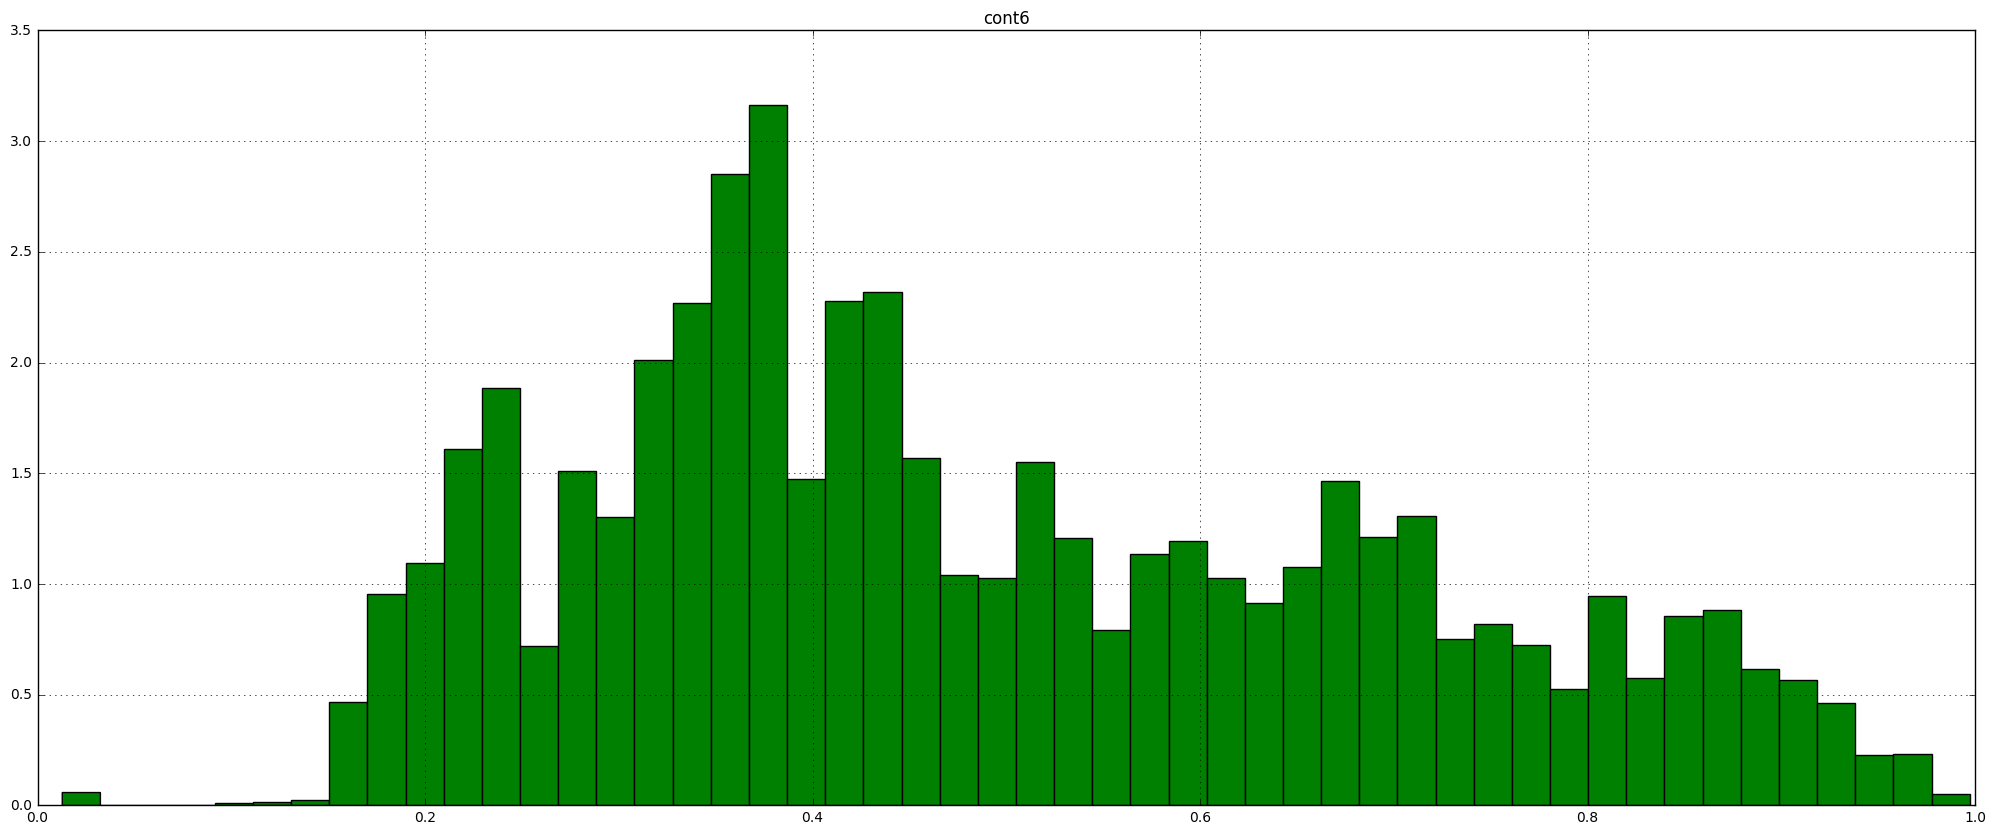

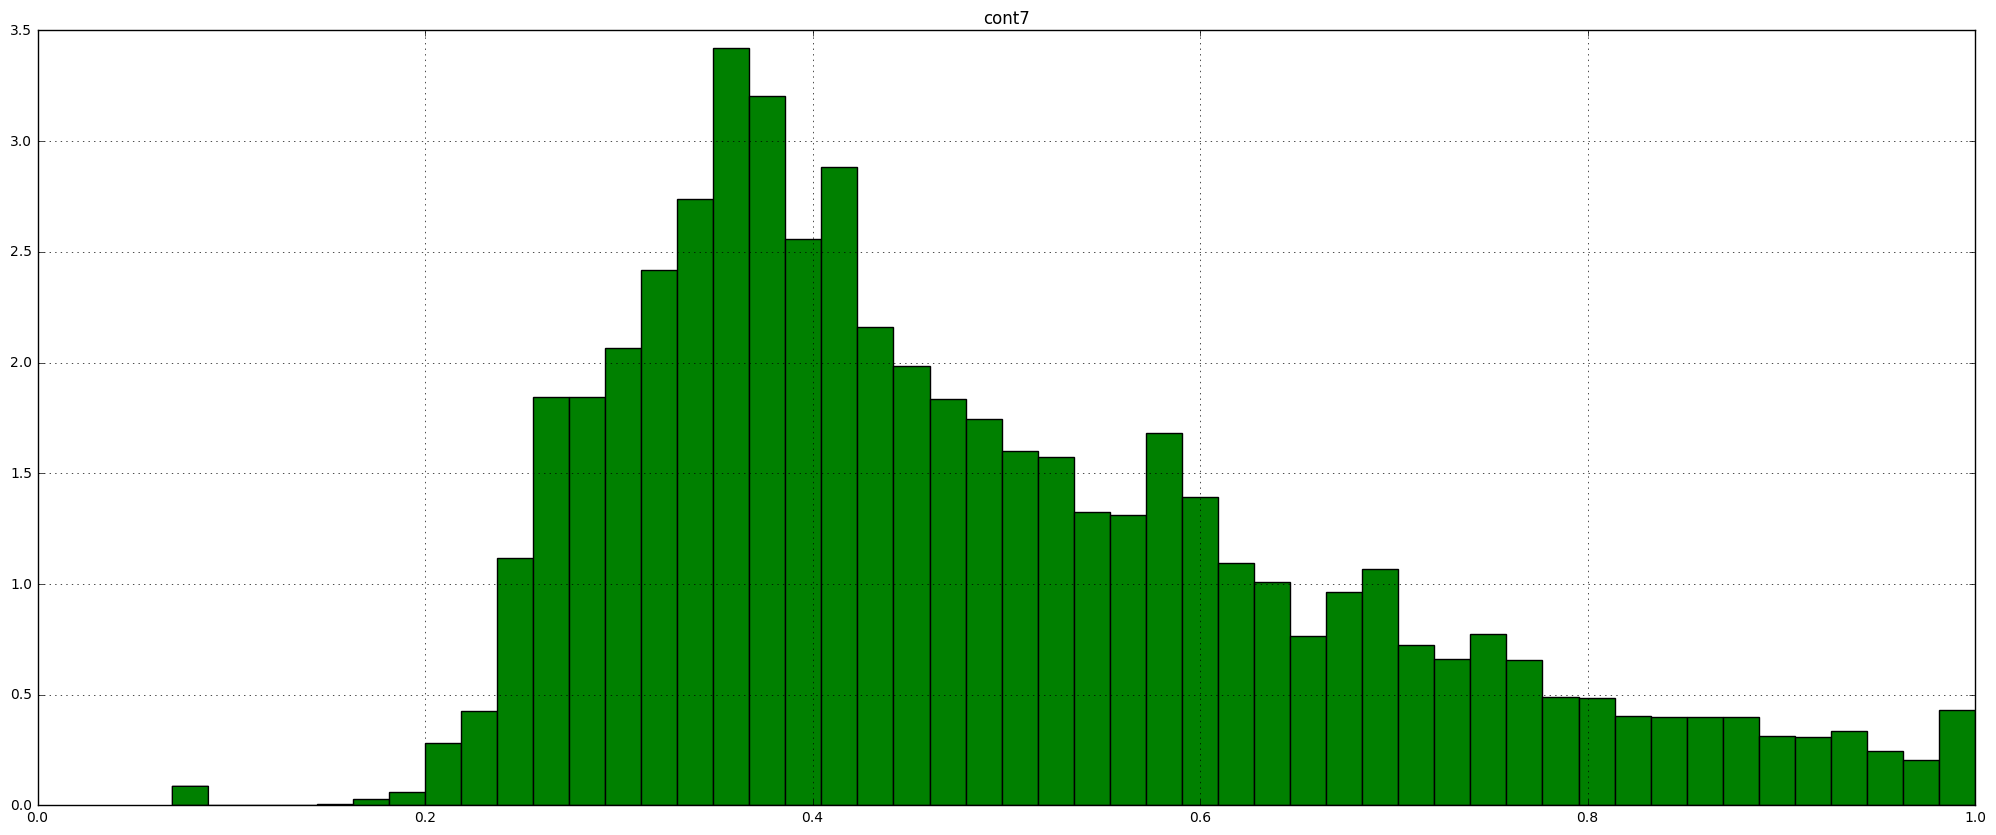

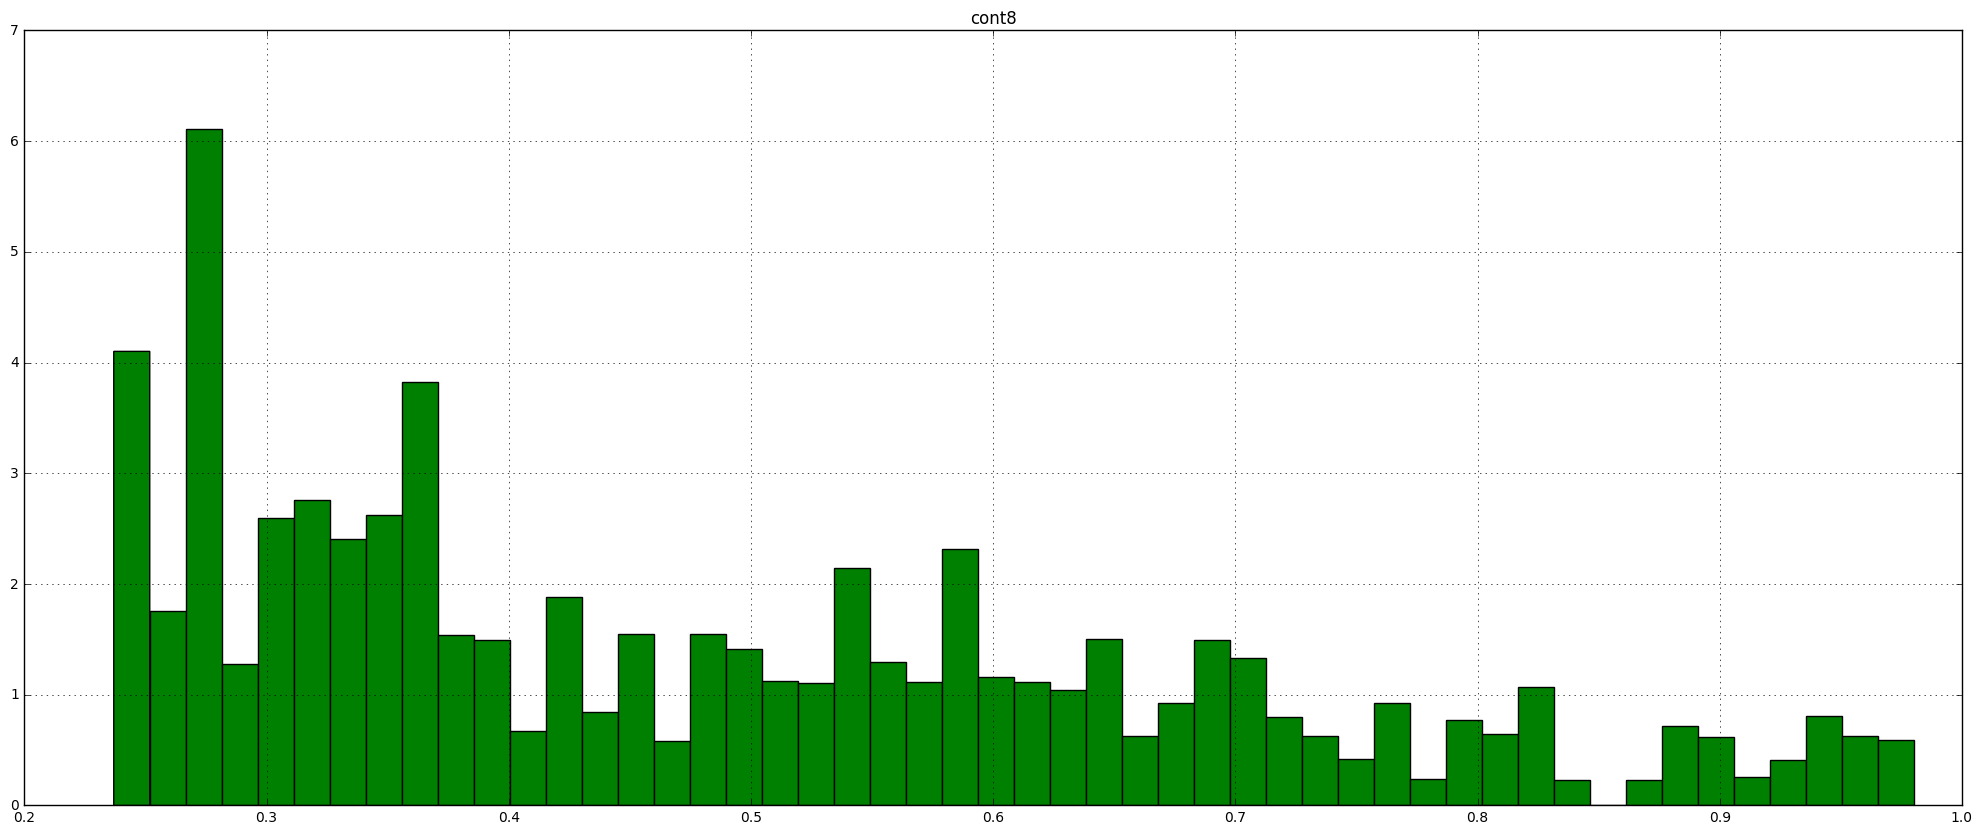

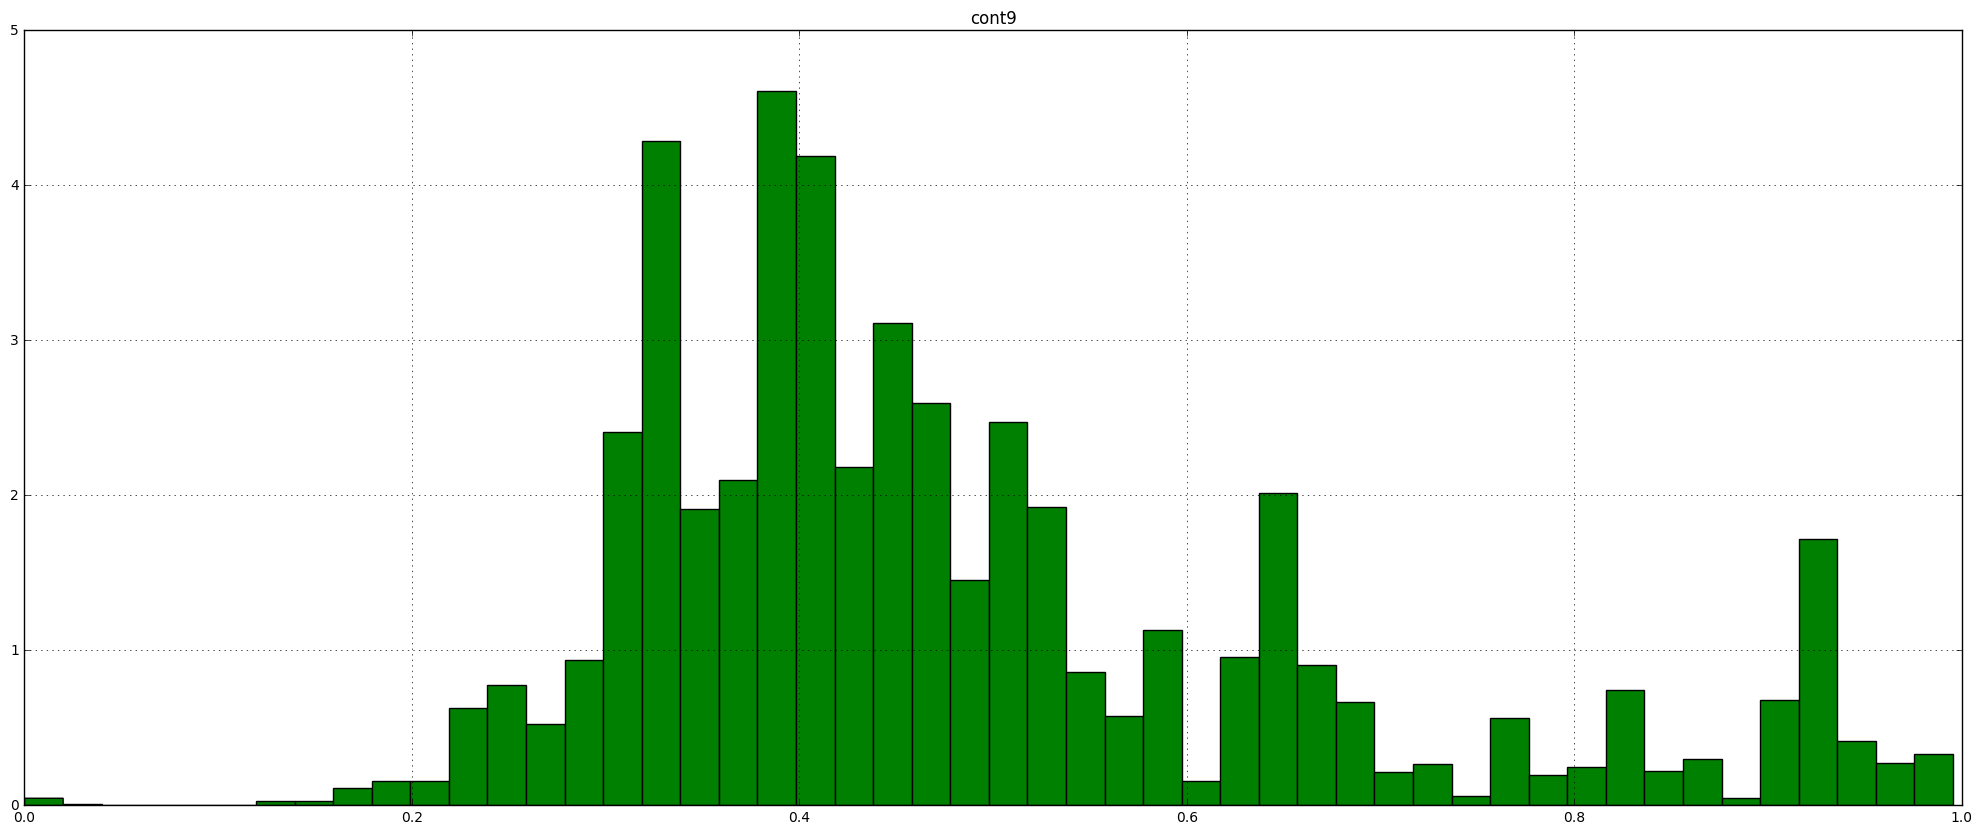

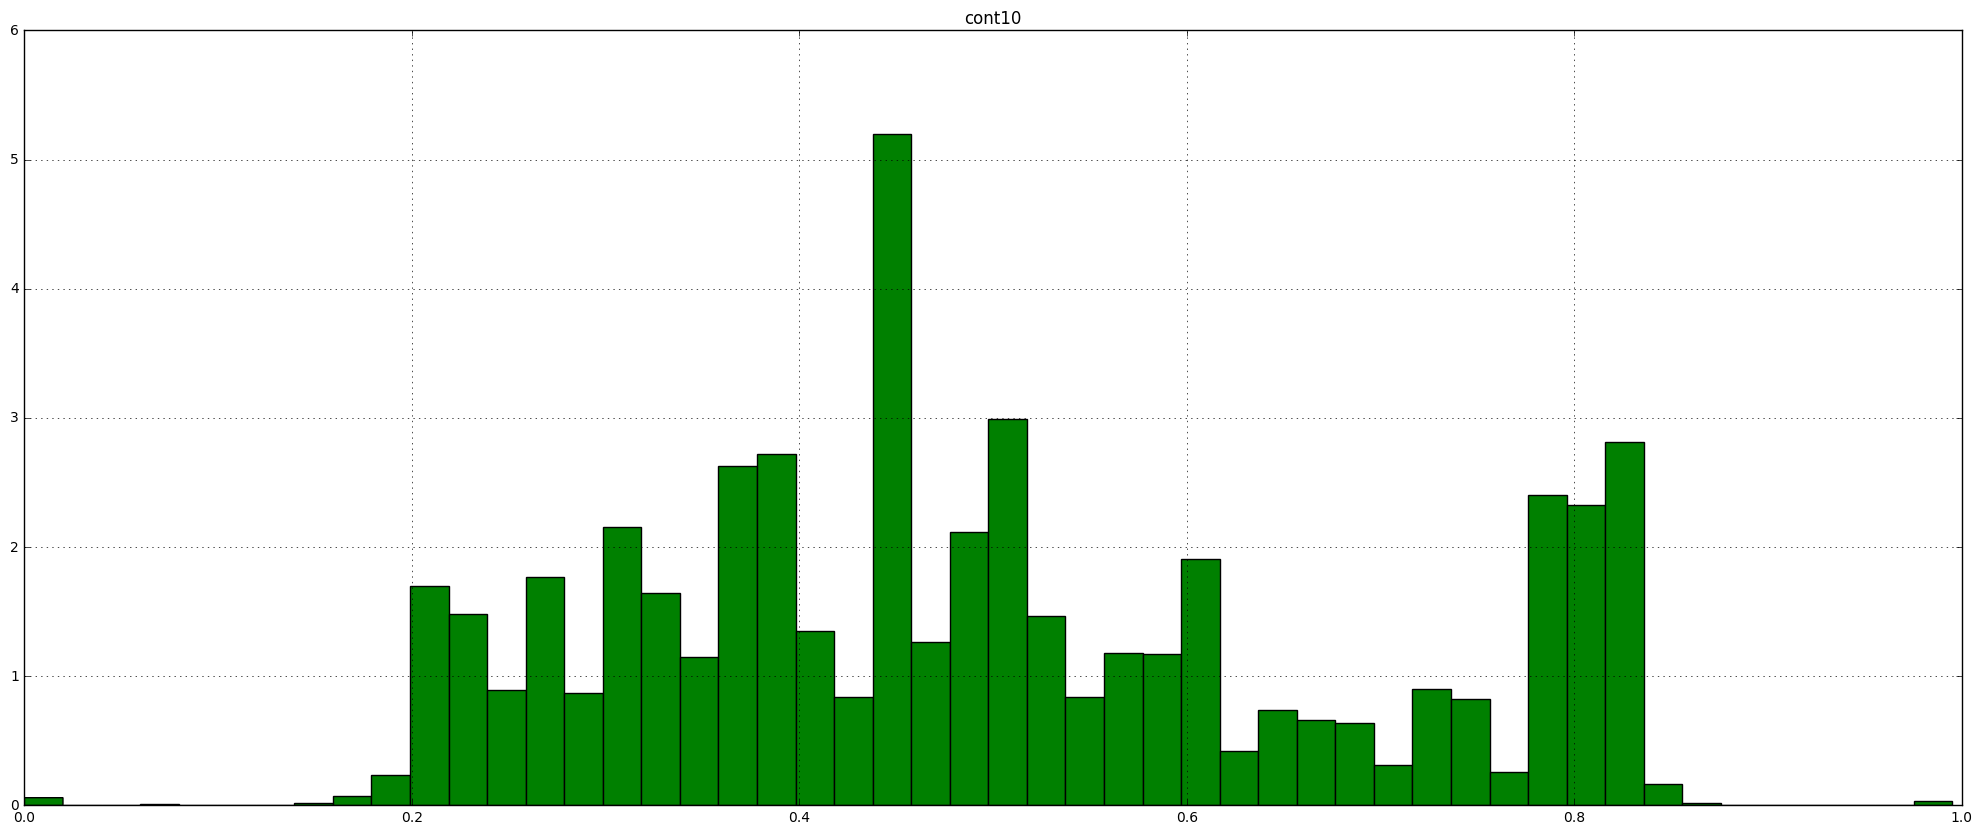

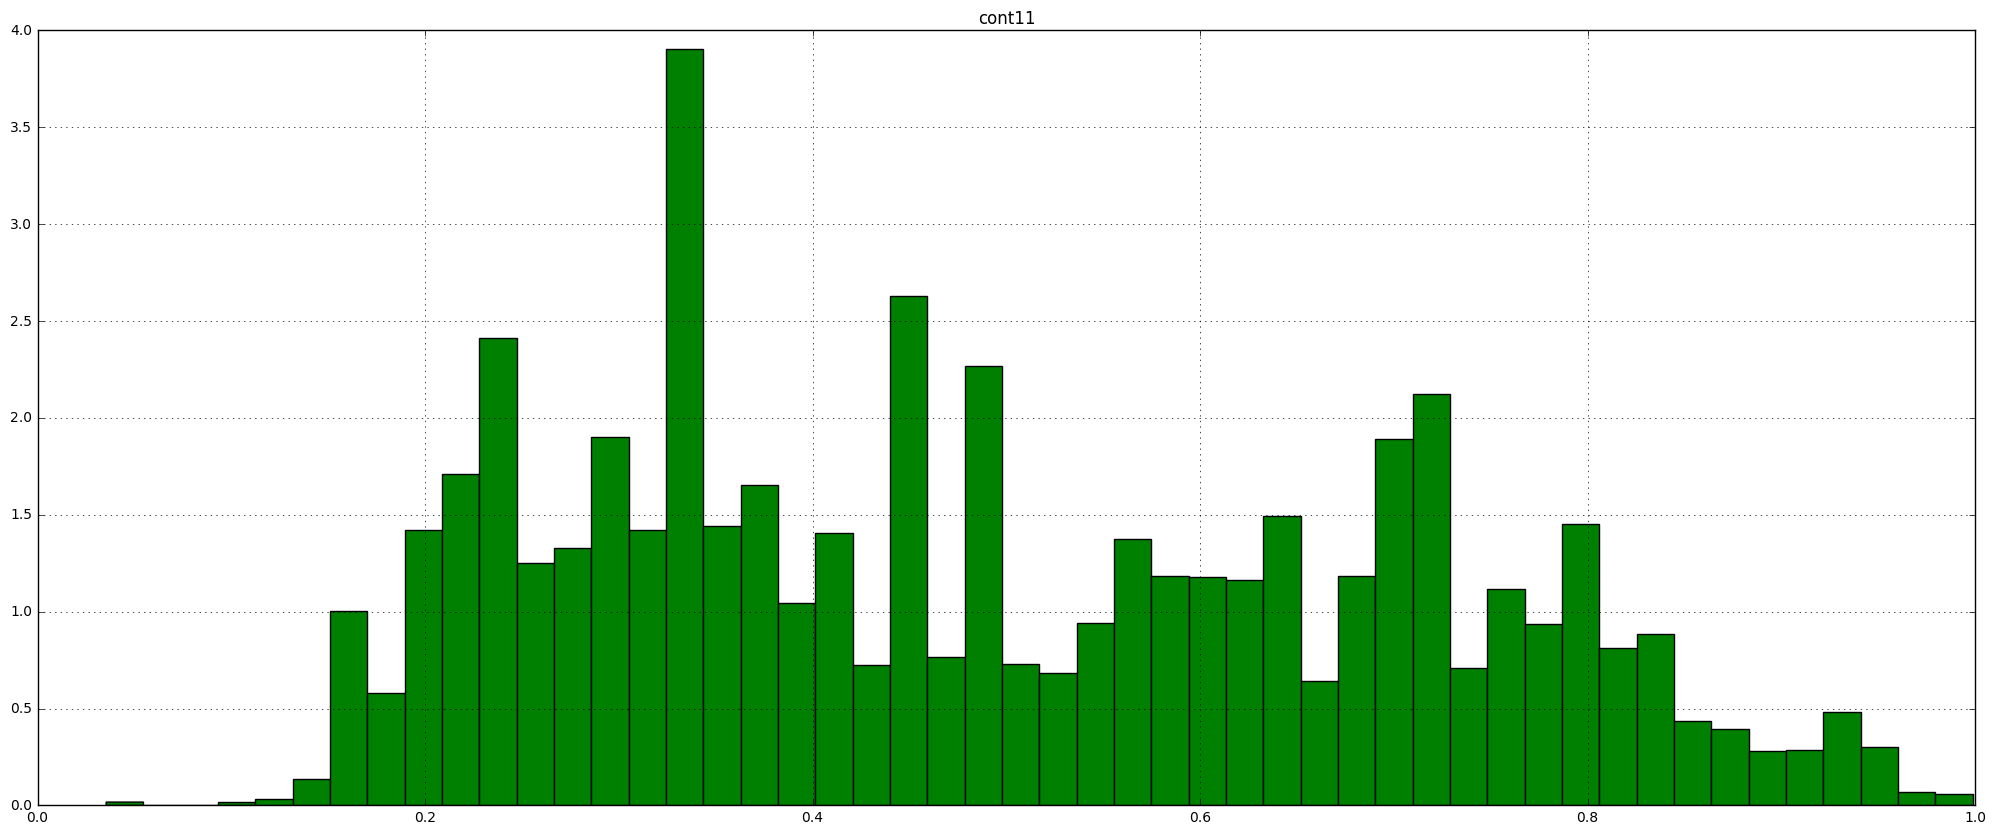

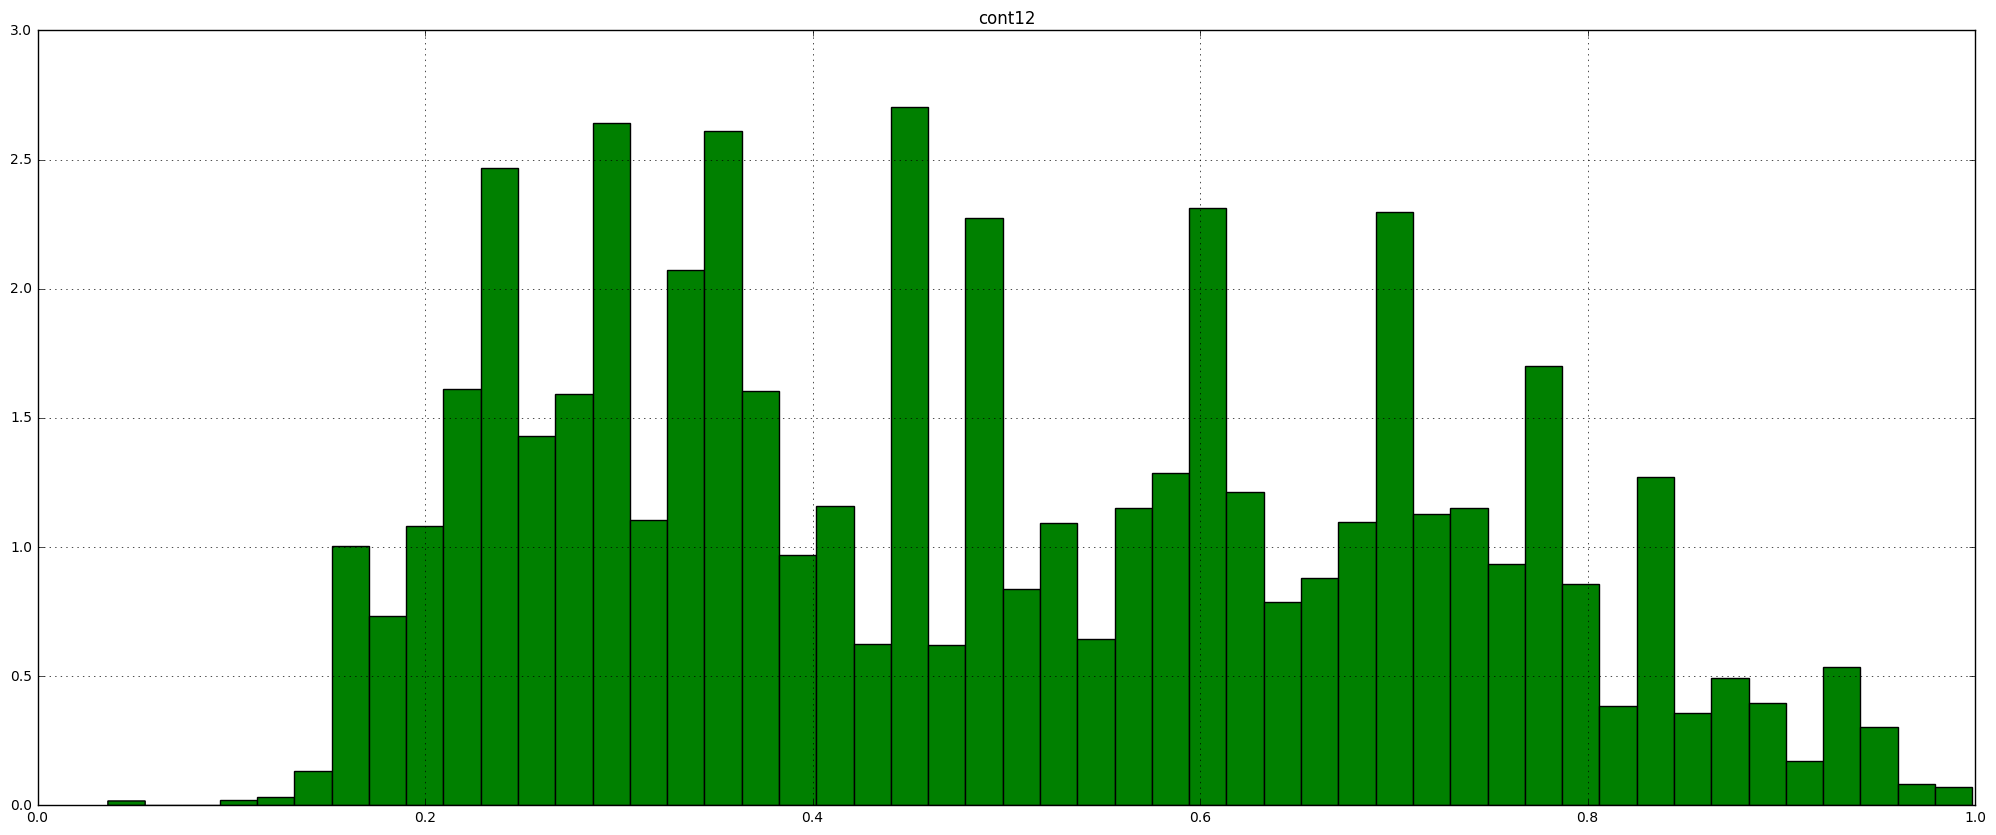

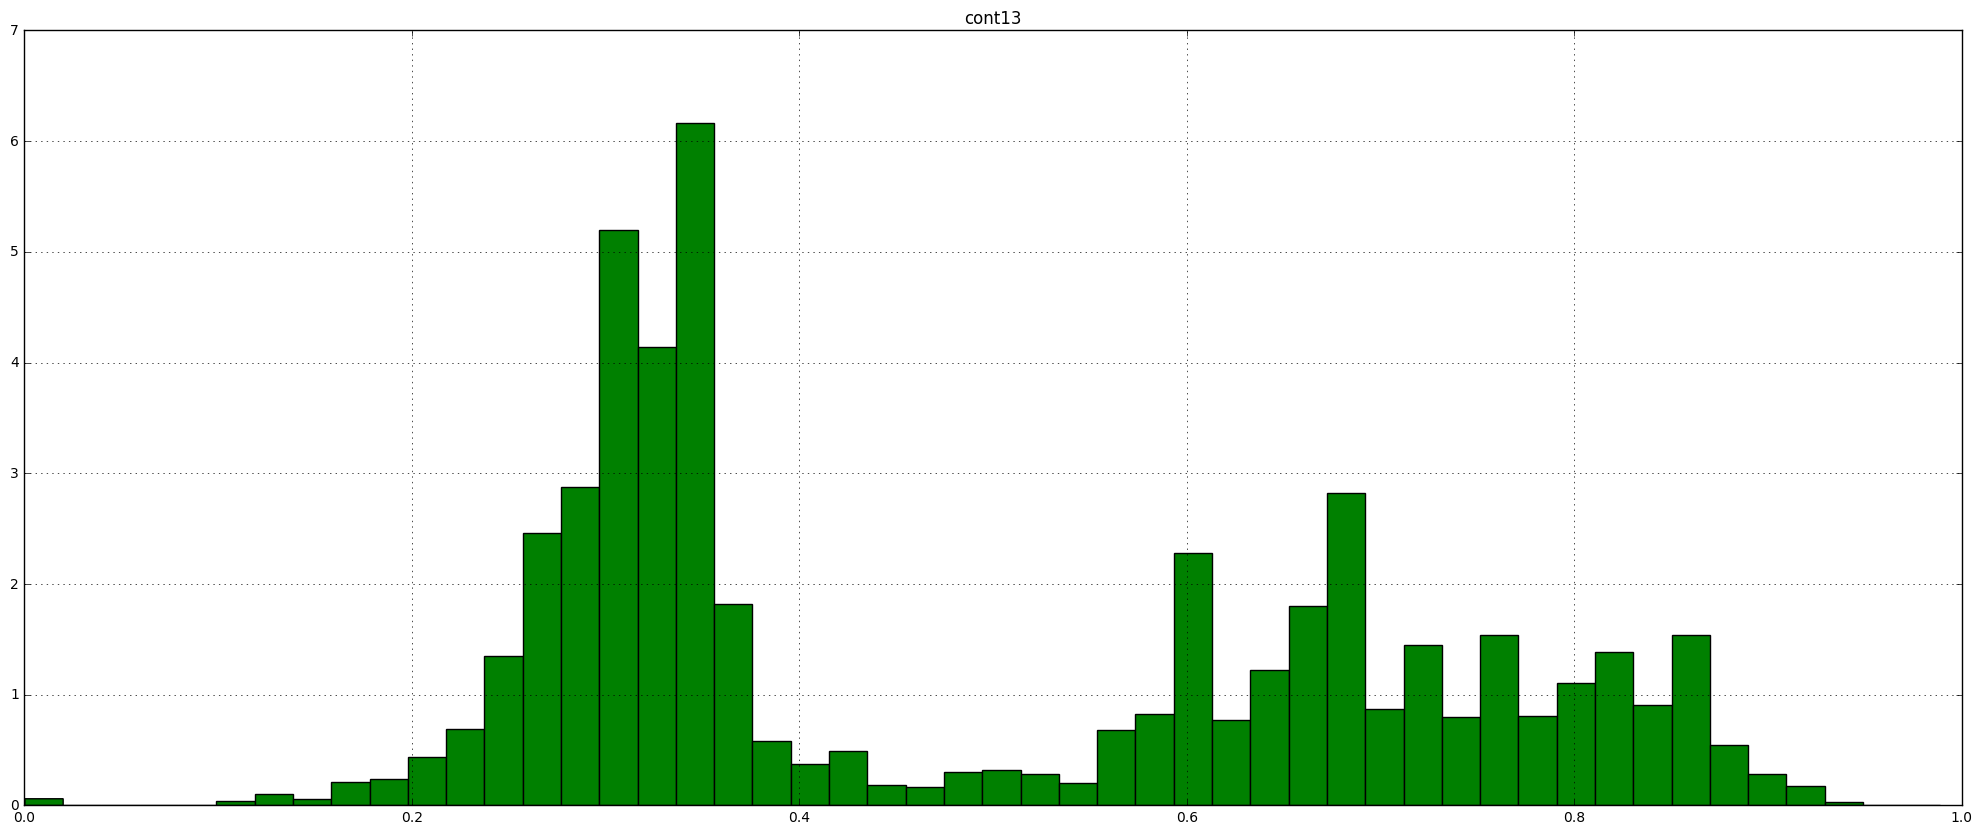

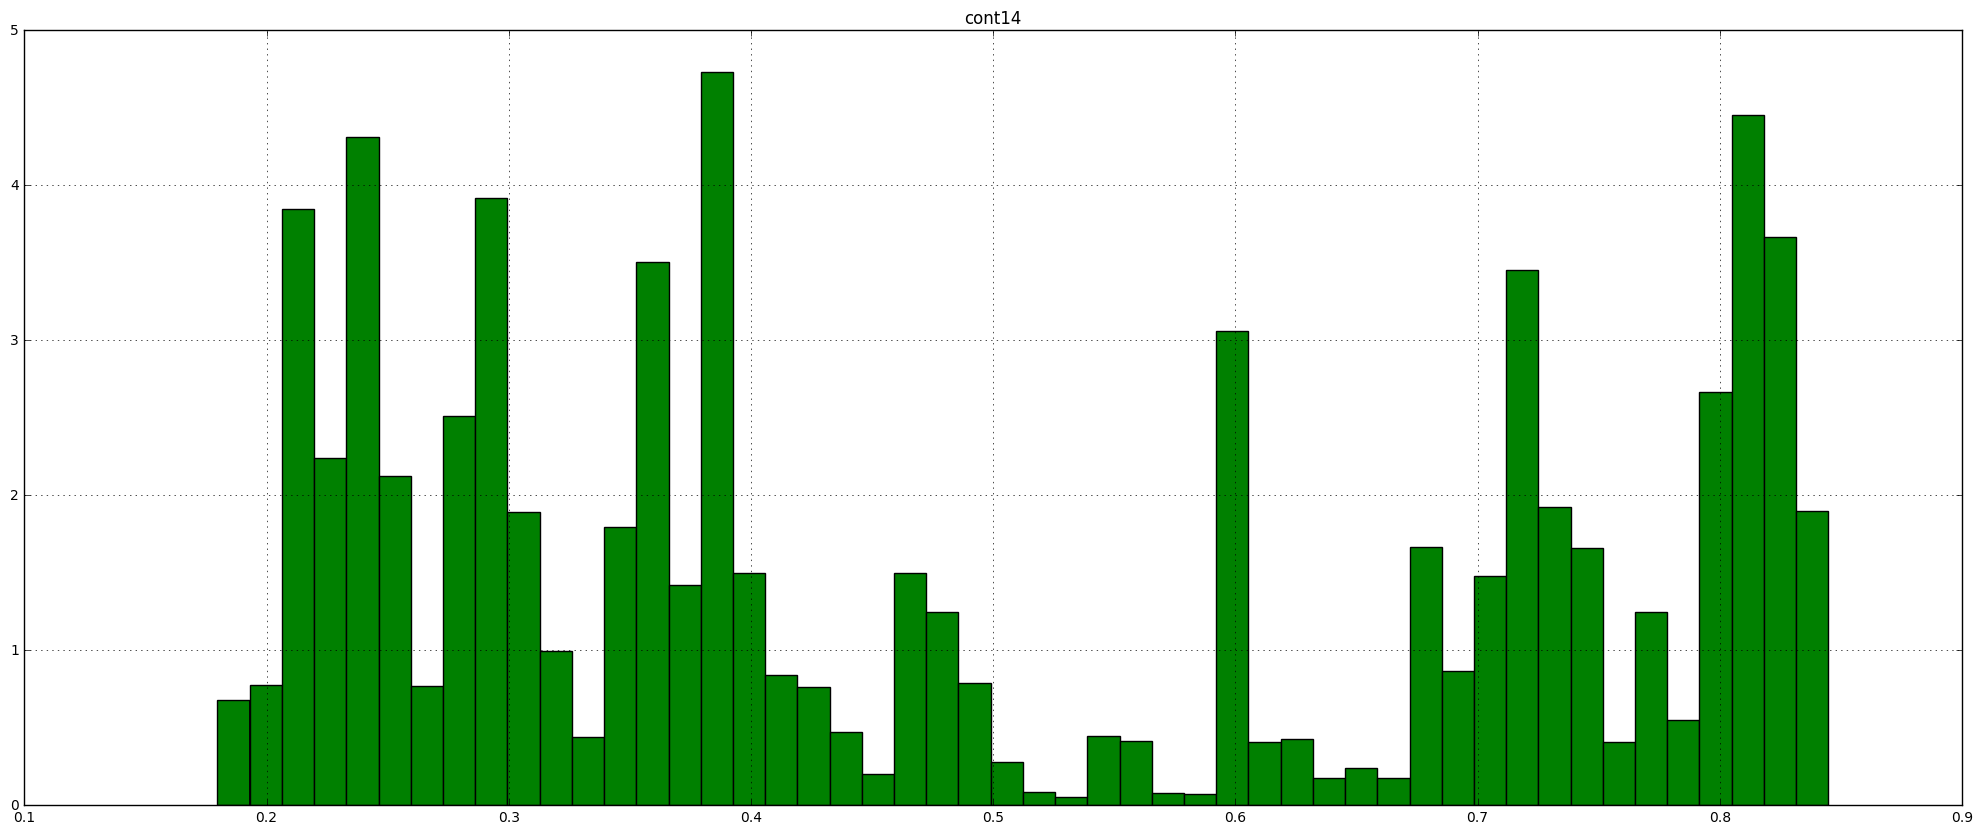

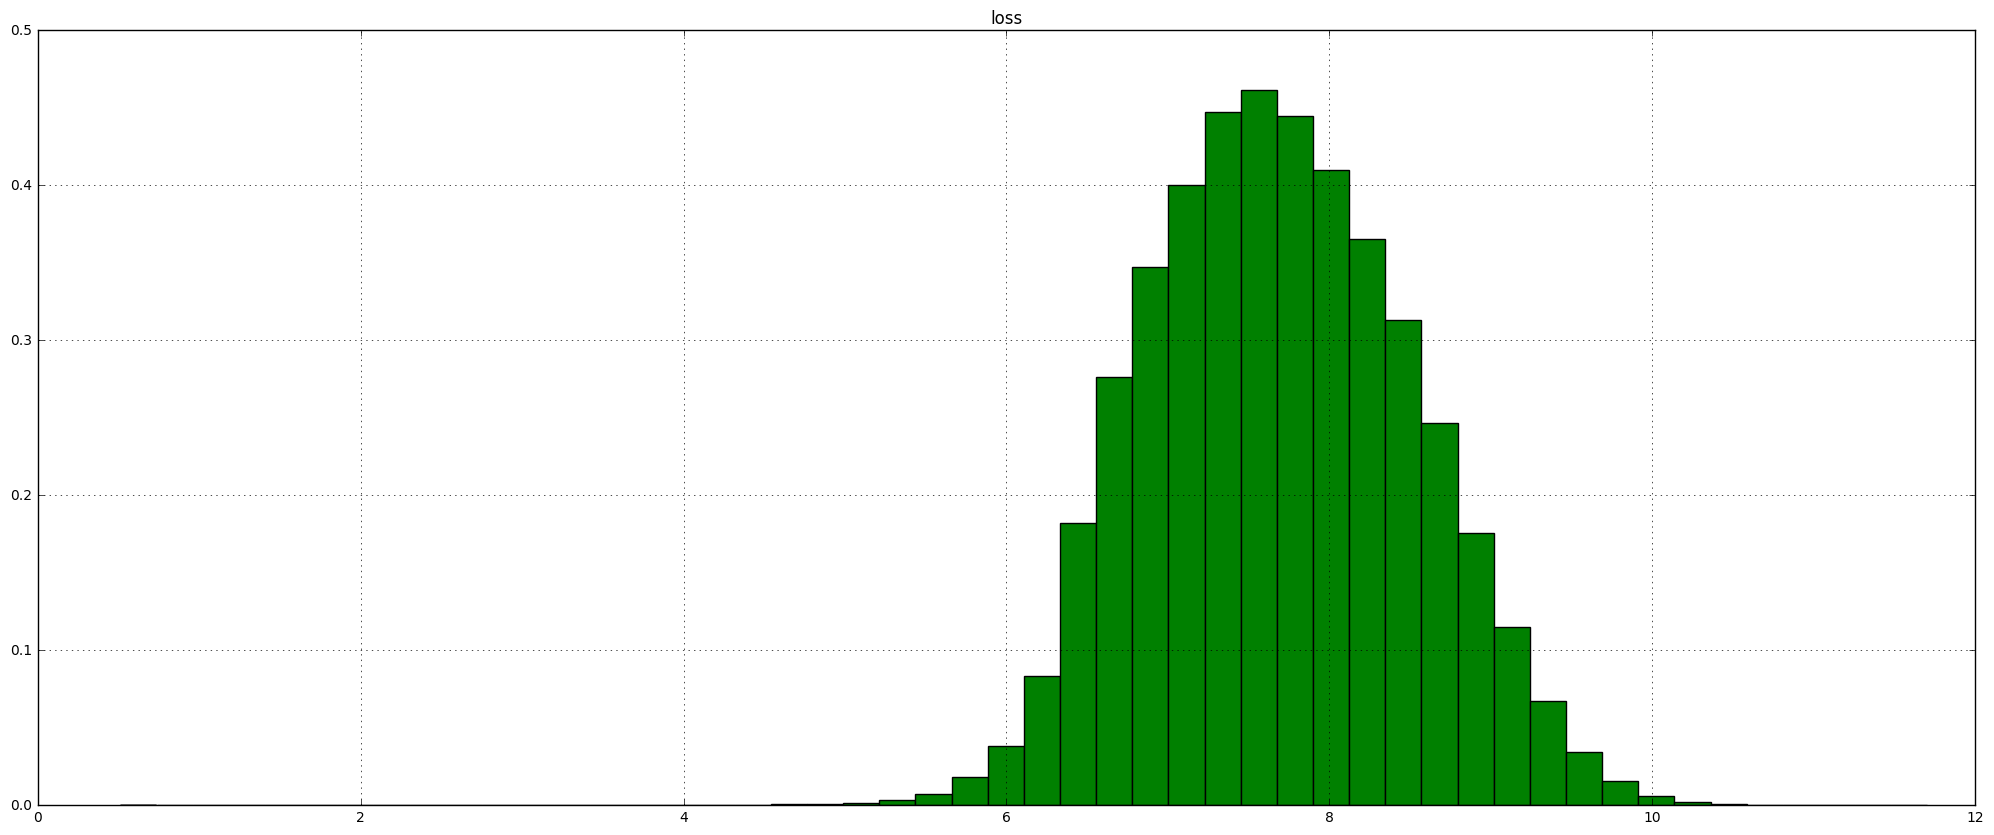

In [91]:
# Take log of skewed continuous columns
from scipy.stats import skew
skewed_feats = []
for feat in numcols:
    if skew(dataset[feat]) > 2:
        skewed_feats += [feat]

dataset[skewed_feats] = np.log1p(dataset[skewed_feats])
skewed_feats.remove('loss')
dataset_test[skewed_feats] = np.log1p(dataset_test[skewed_feats])

for feat in numcols:
    n, bins, patches = plt.hist(dataset[feat], 50, normed=True, facecolor='green')
    plt.title(feat)
    plt.grid(True)
    plt.show()

In [17]:
# Calculates correlations for all combinations
data_corr = dataset[numcols].corr()

# Set the threshold to select only highly correlated attributes
threshold = 0.5

# List of pairs along with correlation above threshold
corr_list = []

size = len(numcols)
#Search for the highly correlated pairs
for i in range(0,size): #for 'size' features
    for j in range(i+1,size): #avoid repetition
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) #store correlation and columns index

#Sort to show higher ones first            
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

#Print correlations and column names
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (numcols[i],numcols[j],v))

# Strong correlation is observed between the following pairs
# This represents an opportunity to reduce the feature set through transformations such as PCA

cont11 and cont12 = 0.99
cont1 and cont9 = 0.93
cont6 and cont10 = 0.88
cont6 and cont13 = 0.82
cont1 and cont10 = 0.81
cont6 and cont9 = 0.80
cont9 and cont10 = 0.79
cont6 and cont12 = 0.79
cont6 and cont11 = 0.77
cont1 and cont6 = 0.76
cont7 and cont11 = 0.75
cont7 and cont12 = 0.74
cont10 and cont12 = 0.71
cont10 and cont13 = 0.71
cont10 and cont11 = 0.70
cont6 and cont7 = 0.66
cont9 and cont13 = 0.64
cont9 and cont12 = 0.63
cont1 and cont12 = 0.61
cont9 and cont11 = 0.61
cont1 and cont11 = 0.60
cont1 and cont13 = 0.53
cont4 and cont8 = 0.53


In [18]:
# This suggests that we can drop cont11, cont6, and cont1
# But since interpretability is already limited given anonymized variables, we can keep them for now.

In [92]:
#OneHotEncoding
import pandas

#cat1 to cat116 have strings. The ML algorithms we are going to study require numberical data
#One-hot encoding converts an attribute to a binary vector

#Variable to hold the list of variables for an attribute in the train and test data
labels = []

cols = dataset.columns
for i in range(0,split):
    train = dataset[cols[i]].unique()
    test = dataset_test[cols[i]].unique()
    labels.append(list(set(train) | set(test)))    

del dataset_test

#Import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#One hot encode all categorical attributes
cats = []
for i in range(0, split):
    #Label encode
    label_encoder = LabelEncoder()
    label_encoder.fit(labels[i])
    feature = label_encoder.transform(dataset.iloc[:,i])
    feature = feature.reshape(dataset.shape[0], 1)
    #One hot encode
    onehot_encoder = OneHotEncoder(sparse=False,n_values=len(labels[i]))
    feature = onehot_encoder.fit_transform(feature)
    cats.append(feature)

# Make a 2D array from a list of 1D arrays
encoded_cats = np.column_stack(cats)

# Print the shape of the encoded data
print(encoded_cats.shape)

#Concatenate encoded attributes with continuous attributes
dataset_encoded = np.concatenate((encoded_cats,dataset.iloc[:,split:].values),axis=1)
del cats
del feature
del dataset
del encoded_cats
print(dataset_encoded.shape)

(188318, 1176)
(188318, 1191)


In [37]:
#get the number of rows and columns
r, c = dataset_encoded.shape

#create an array which has indexes of columns
i_cols = []
for i in range(0,c-1):
    i_cols.append(i)

#Y is the target column, X has the rest
X = dataset_encoded[:,0:(c-1)]
Y = dataset_encoded[:,(c-1)]
del dataset_encoded

#Validation chunk size
val_size = 0.1

#Use a common seed in all experiments so that same chunk is used for validation
seed = 0

#Split the data into chunks
from sklearn import cross_validation
X_train, X_val, Y_train, Y_val = cross_validation.train_test_split(X, Y, test_size=val_size, random_state=seed)
del X
del Y

#All features
X_all = []

#List of combinations
comb = []

#Dictionary to store the MAE for all algorithms 
mae = []

#Scoring parameter
from sklearn.metrics import mean_absolute_error

#Add this version of X to the list 
n = "All"
#X_all.append([n, X_train,X_val,i_cols])
X_all.append([n, i_cols])

All 1213.13686498


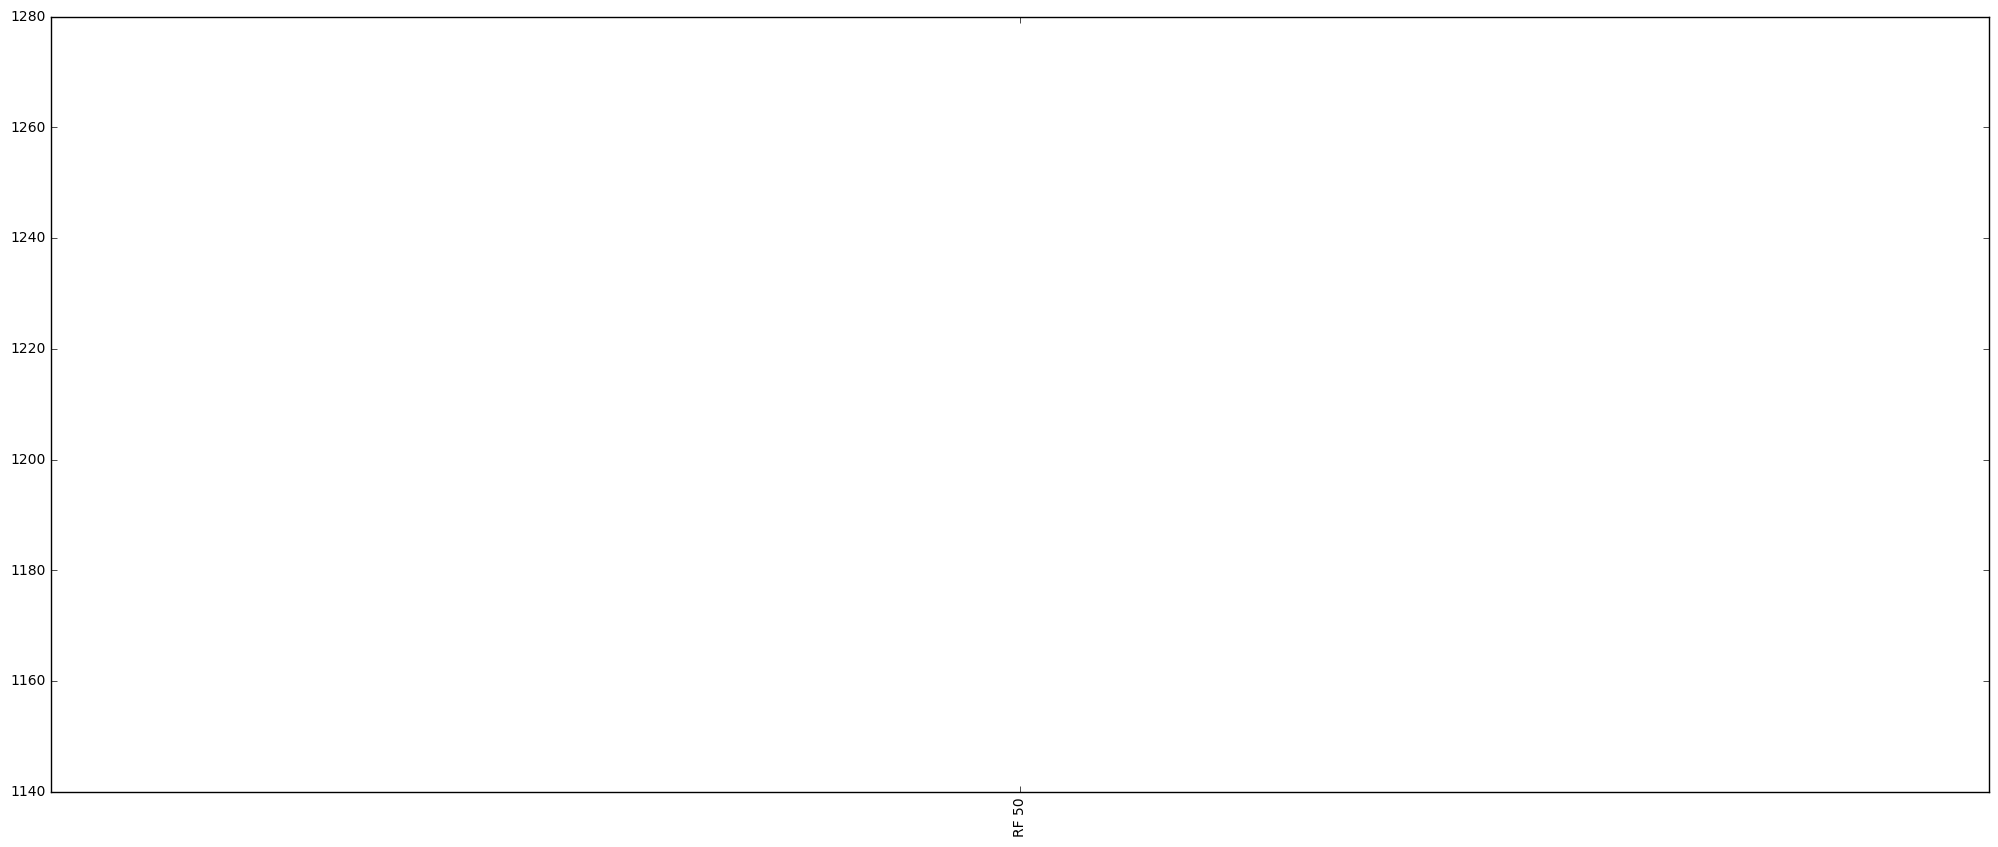

In [21]:
#Evaluation of various combinations of RandomForest

#Import the library
from sklearn.ensemble import RandomForestRegressor

#Add the n_estimators value to the below list if you want to run the algo
n_list = np.array([50])

for n_estimators in n_list:
    #Set the base model
    model = RandomForestRegressor(n_jobs=-1,n_estimators=n_estimators,random_state=seed)
    
    algo = "RF"

    #Accuracy of the model using all features
    for name,i_cols_list in X_all:
        model.fit(X_train[:,i_cols_list],Y_train)
        result = mean_absolute_error(np.expm1(Y_val), np.expm1(model.predict(X_val[:,i_cols_list])))
        mae.append(result)
        print(name + " %s" % result)
        
    comb.append(algo + " %s" % n_estimators )    
    
#Set figure size
plt.rc("figure", figsize=(25, 10))

#Plot the MAE of all combinations
fig, ax = plt.subplots()
plt.plot(mae)
#Set the tick names to names of combinations
ax.set_xticks(range(len(comb)))
ax.set_xticklabels(comb,rotation='vertical')
#Plot the accuracy for all combinations
plt.show()    

#Best estimated performance is 1213 when the number of estimators is 50

All 1168.87161705


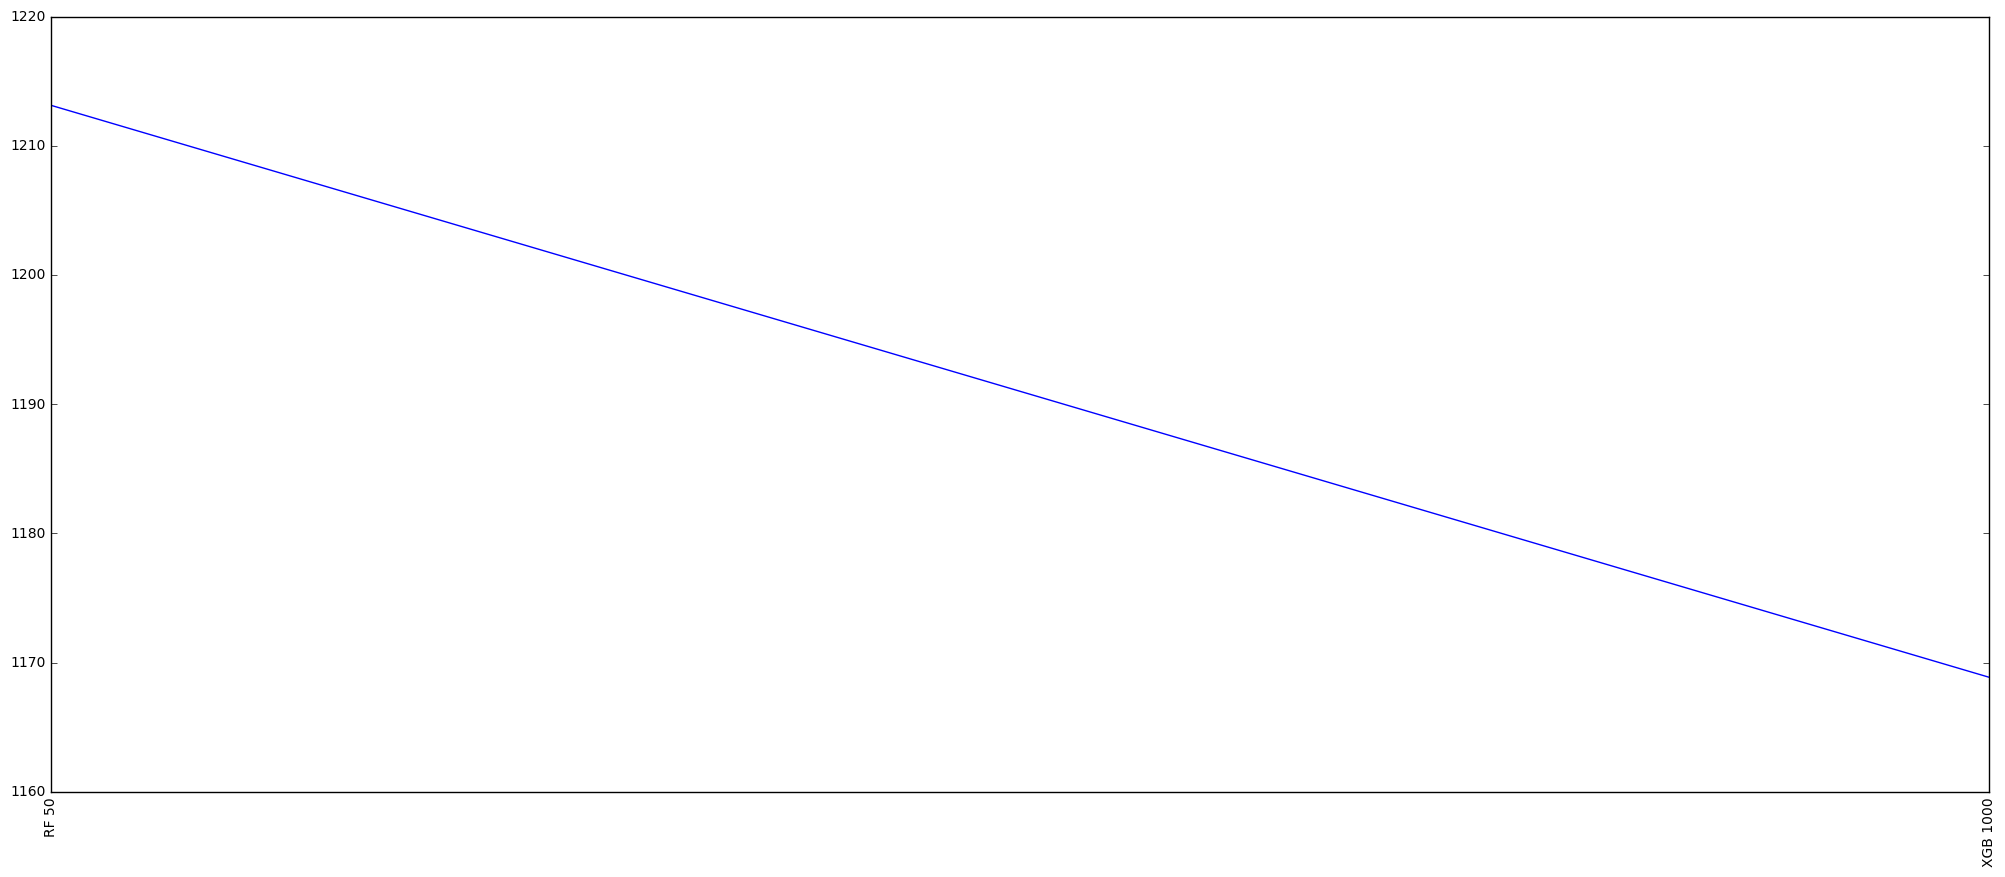

In [22]:
#Evaluation of various combinations of XGB

#Import the library
from xgboost import XGBRegressor

#Add the n_estimators value to the below list if you want to run the algo
n_list = np.array([1000])

for n_estimators in n_list:
    #Set the base model
    model = XGBRegressor(n_estimators=n_estimators,seed=seed)
    
    algo = "XGB"

    #Accuracy of the model using all features
    for name,i_cols_list in X_all:
        model.fit(X_train[:,i_cols_list],Y_train)
        result = mean_absolute_error(np.expm1(Y_val), np.expm1(model.predict(X_val[:,i_cols_list])))
        mae.append(result)
        print(name + " %s" % result)
        
    comb.append(algo + " %s" % n_estimators )
    
#Set figure size
plt.rc("figure", figsize=(25, 10))

#Plot the MAE of all combinations
fig, ax = plt.subplots()
plt.plot(mae)
#Set the tick names to names of combinations
ax.set_xticks(range(len(comb)))
ax.set_xticklabels(comb,rotation='vertical')
#Plot the accuracy for all combinations
plt.show()    

#Best estimated performance is 1169 with n=1000

In [38]:
# Make predictions using XGB as it gave the best estimated performance        

X = np.concatenate((X_train,X_val),axis=0)
del X_train
del X_val
Y = np.concatenate((Y_train,Y_val),axis=0)
del Y_train
del Y_val

n_estimators = 1000

#Best model definition
best_model = XGBRegressor(n_estimators=n_estimators,seed=seed)
best_model.fit(X,Y)
del X
del Y

In [93]:
#Read test dataset
dataset_test = pandas.read_csv("../../datasets/allstate/test.csv")
#Drop unnecessary columns
ID = dataset_test['id']
dataset_test.drop('id',axis=1,inplace=True)

#One hot encode all categorical attributes
cats = []
for i in range(0, split):
    #Label encode
    label_encoder = LabelEncoder()
    label_encoder.fit(labels[i])
    feature = label_encoder.transform(dataset_test.iloc[:,i])
    feature = feature.reshape(dataset_test.shape[0], 1)
    #One hot encode
    onehot_encoder = OneHotEncoder(sparse=False,n_values=len(labels[i]))
    feature = onehot_encoder.fit_transform(feature)
    cats.append(feature)

# Make a 2D array from a list of 1D arrays
encoded_cats = np.column_stack(cats)

del cats

#Concatenate encoded attributes with continuous attributes
X_test = np.concatenate((encoded_cats,dataset_test.iloc[:,split:].values),axis=1)
print(X_test)
del dataset_test

#Make predictions using the best model
predictions = np.expm1(best_model.predict(X_test))

# # Write submissions to output file in the correct format
# with open("submission.csv", "w") as subfile:
#     subfile.write("id,loss\n")
#     for i, pred in enumerate(list(predictions)):
#         subfile.write("%s,%s\n"%(ID[i],pred))

[[ 1.        0.        0.       ...,  0.369858  0.704052  0.392562]
 [ 1.        0.        0.       ...,  0.675759  0.453468  0.208045]
 [ 1.        0.        0.       ...,  0.241676  0.258586  0.297232]
 ..., 
 [ 0.        1.        0.       ...,  0.926619  0.848129  0.808125]
 [ 1.        0.        1.       ...,  0.301921  0.608259  0.361542]
 [ 1.        0.        0.       ...,  0.241676  0.287682  0.220323]]


This achieves a score of 1138.70593 on the public leaderboard, which is actually lower than the score we got with our local train/test set.

1189
1176


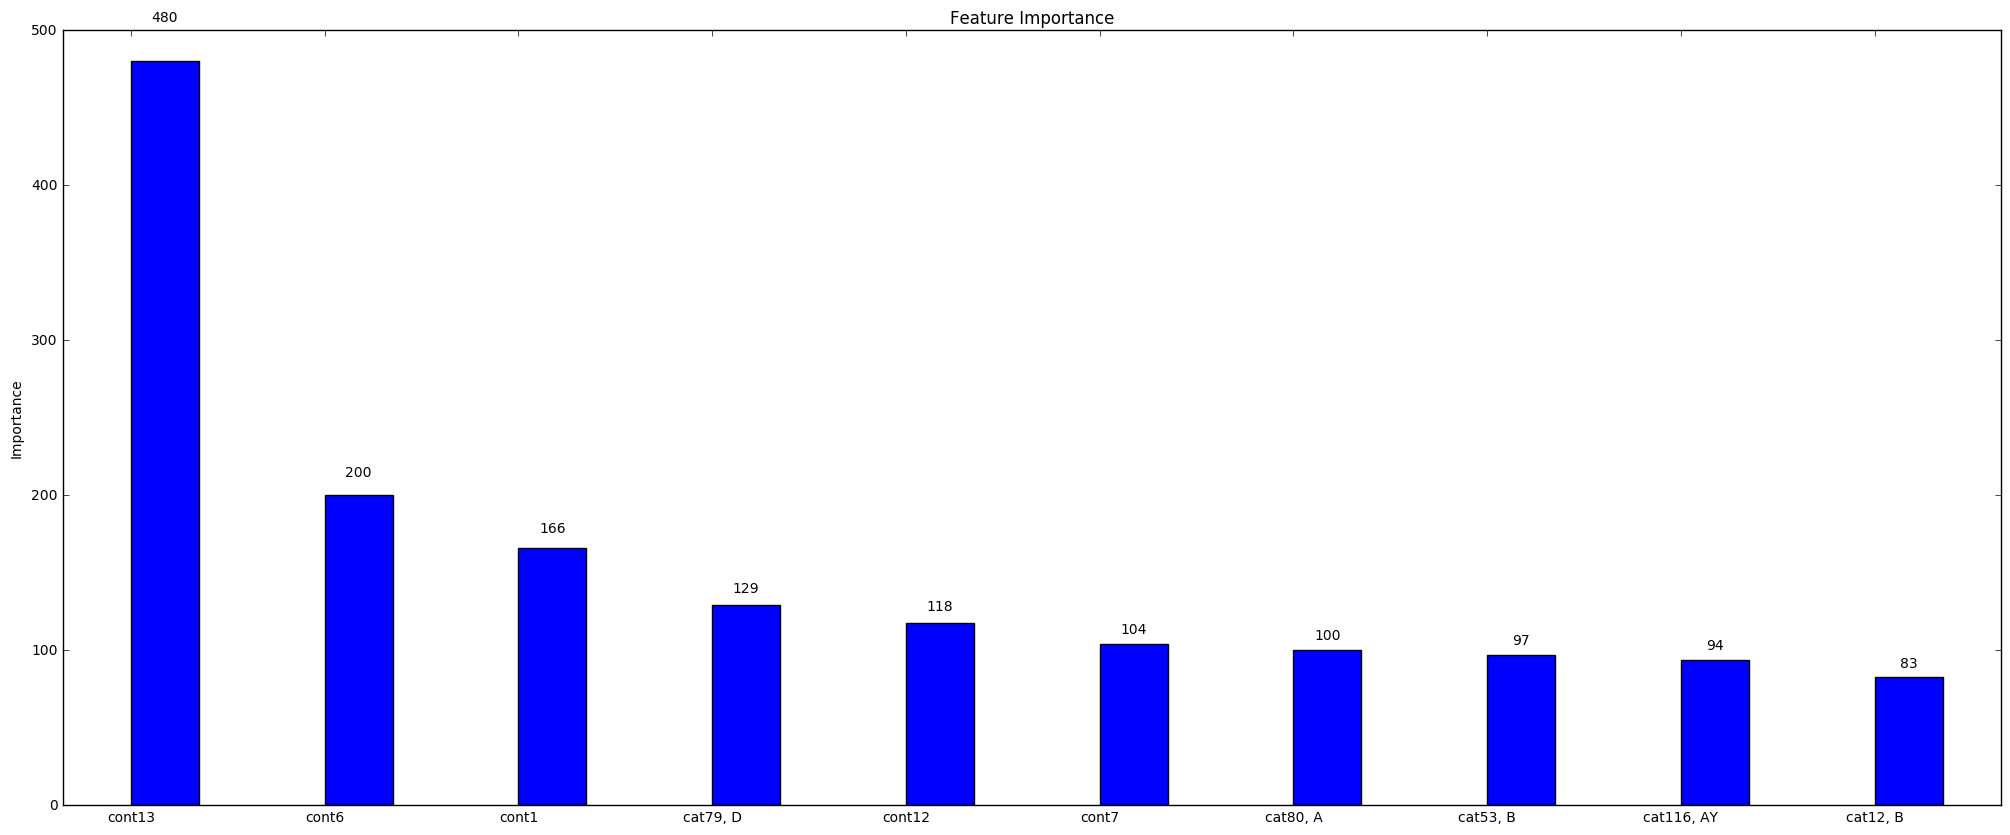

In [119]:
#Find the most important features
from xgboost import plot_importance
import matplotlib.pyplot as plt
import copy

#get the most important
importance = best_model.booster().get_score()
tuples = [(k, importance[k]) for k in importance]
tuples = sorted(tuples, key=lambda x: x[1], reverse=True)
xlabels, values = zip(*tuples)

#convert back to original form
def deep_len(lst):
    return sum(deep_len(el) if isinstance(el, list) else 1 for el in lst)

def get_deep_ele(deep_lst, n):
    lst = copy.deepcopy(deep_lst)
    var = 1
    while n >= len(lst[0]):
        lst = lst[1:]
        n -= len(lst[0])
        var += 1
    return str(var) + ', ' + lst[0][n]

xlabels = [int(el[1:]) for el in xlabels]
print(max(xlabels))
print(deep_len(labels))

def xlabel_to_feature(n):
    if n > 1176:
        return "cont" + str(n-1176)
    else:
        return "cat" + get_deep_ele(labels, n)

ind = np.arange(10)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(ind + width, values[:10], width, color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('Importance')
ax.set_title('Feature Importance')
ax.set_xticks(ind + width)
ax.set_xticklabels([xlabel_to_feature(i) for i in xlabels[:10]])

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
plt.show()


So we see that the strongest predictors of loss are cont6, cont13, and cont1. Note that cont6 and cont13 are strongly correlated with each other. But since the dataset is anonymized, it is hard to draw conclusions from or interpret the model beyond this.

In [ ]:
cont11 and cont12 = 0.99
cont1 and cont9 = 0.93
cont6 and cont10 = 0.88
cont6 and cont13 = 0.82
cont1 and cont10 = 0.81
cont6 and cont9 = 0.80
cont9 and cont10 = 0.79
cont6 and cont12 = 0.79
cont6 and cont11 = 0.77
cont1 and cont6 = 0.76
cont7 and cont11 = 0.75
cont7 and cont12 = 0.74
cont10 and cont12 = 0.71
cont10 and cont13 = 0.71
cont10 and cont11 = 0.70
cont6 and cont7 = 0.66
cont9 and cont13 = 0.64
cont9 and cont12 = 0.63
cont1 and cont12 = 0.61
cont9 and cont11 = 0.61
cont1 and cont11 = 0.60
cont1 and cont13 = 0.53
cont4 and cont8 = 0.53